# Library utilized

In [1]:
import pandas as pd
import numpy as np
from scipy.signal import butter, lfilter, gaussian, find_peaks
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import skew, kurtosis, entropy
from scipy.ndimage import filters
from numpy.fft import fft
from scipy.integrate import trapz
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from scipy.stats.mstats import winsorize
from sklearn.cluster import KMeans
from collections import Counter
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split, cross_val_score, LeaveOneOut
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import silhouette_score, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

# Import and categorized RLS and Non-RLS datasets

In [3]:
# Define file paths for the two categories
non_rls_files = ['SittingStillXRLS1.csv','SittingStillXRLS2.csv','SittingStillXRLS3.csv']
rls_files = ['SittingStillRLS1.csv', 'SittingStillRLS2.csv','SittingStillRLS3.csv']

# Dictionary to store datasets categorized by RLS and non-RLS
datasets = {'non_rls': {}, 'rls': {}}

# Loop to read and categorize non-RLS datasets
for i, file in enumerate(non_rls_files):
    datasets['non_rls'][f'non_rls_dataset_{i+1}'] = pd.read_csv(file)

# Loop to read and categorize RLS datasets
for i, file in enumerate(rls_files):
    datasets['rls'][f'rls_dataset_{i+1}'] = pd.read_csv(file)

# Display data types of each dataset for both categories
for category, category_datasets in datasets.items():
    print(f"Category: {category}")
    for name, dataset in category_datasets.items():
        print(f"Data types of {name}:")
        print(dataset.dtypes)
        print("\n")

# Access data types of individual datasets (corrected)
for category, category_datasets in datasets.items():
    for name, dataset in category_datasets.items():
        print(f"{name} Data Types: \n{dataset.dtypes}")


Category: non_rls
Data types of non_rls_dataset_1:
time    float64
gFx     float64
gFy     float64
gFz     float64
TgF     float64
dtype: object


Data types of non_rls_dataset_2:
time    float64
gFx     float64
gFy     float64
gFz     float64
TgF     float64
dtype: object


Data types of non_rls_dataset_3:
time    float64
gFx     float64
gFy     float64
gFz     float64
TgF     float64
dtype: object


Category: rls
Data types of rls_dataset_1:
time    float64
gFx     float64
gFy     float64
gFz     float64
TgF     float64
dtype: object


Data types of rls_dataset_2:
time    float64
gFx     float64
gFy     float64
gFz     float64
TgF     float64
dtype: object


Data types of rls_dataset_3:
time    float64
gFx     float64
gFy     float64
gFz     float64
TgF     float64
dtype: object


non_rls_dataset_1 Data Types: 
time    float64
gFx     float64
gFy     float64
gFz     float64
TgF     float64
dtype: object
non_rls_dataset_2 Data Types: 
time    float64
gFx     float64
gFy     float64
gF

# Low pass filter Non-RLS dataset

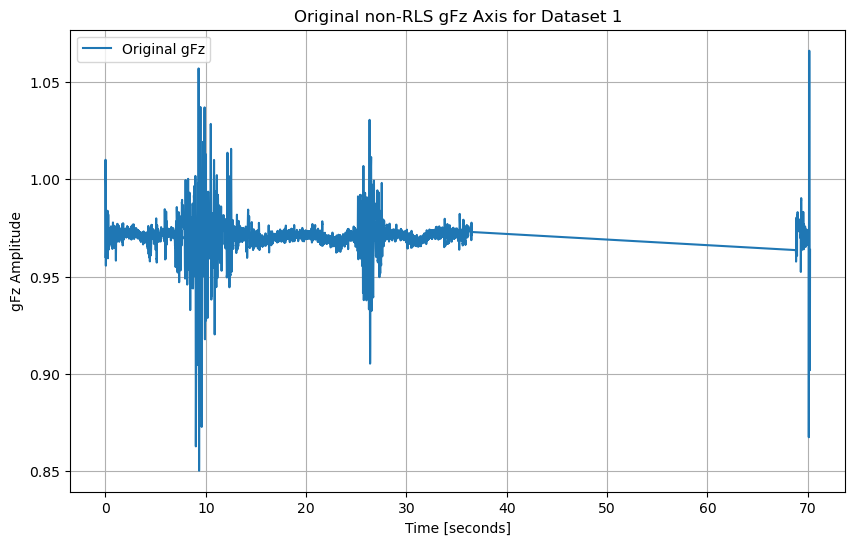

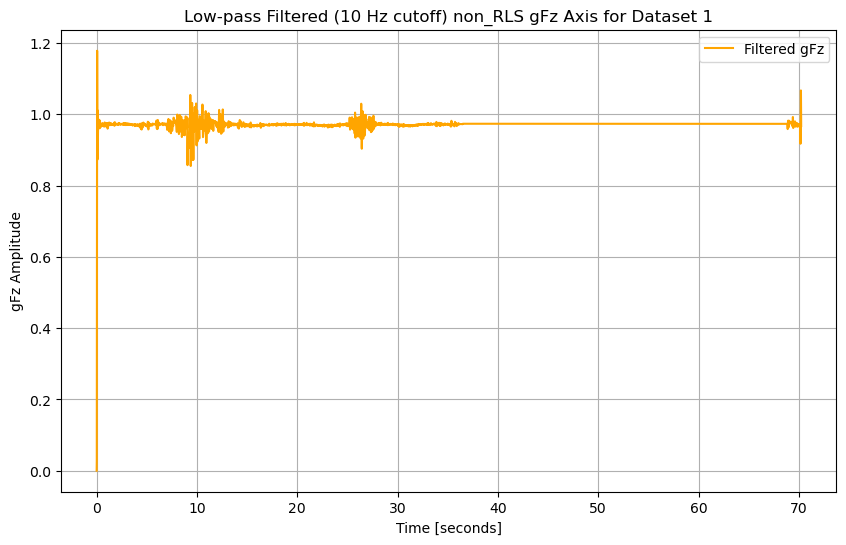

First two segments for dataset 1:
            0             1             2             3         4         5    \
0  4.438973e-10  8.613103e-09  8.308243e-08  5.335791e-07  0.000003  0.000010   
1  1.004557e+00  1.009197e+00  1.010714e+00  1.009307e+00  1.005330  0.999261   

        6         7         8         9    ...       118       119       120  \
0  0.000033  0.000094  0.000239  0.000550  ...  0.971138  0.969491  0.967826   
1  0.991659  0.983129  0.974280  0.965687  ...  0.977440  0.975991  0.974442   

        121       122       123       124       125       126       127  
0  0.966256  0.964886  0.963811  0.963105  0.962821  0.962988  0.963610  
1  0.972846  0.971253  0.969713  0.968271  0.966970  0.965843  0.964917  

[2 rows x 128 columns]


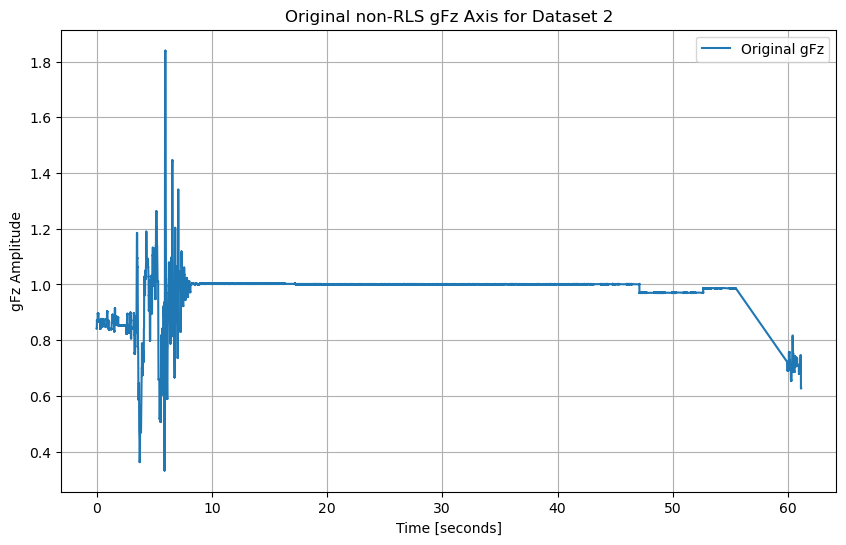

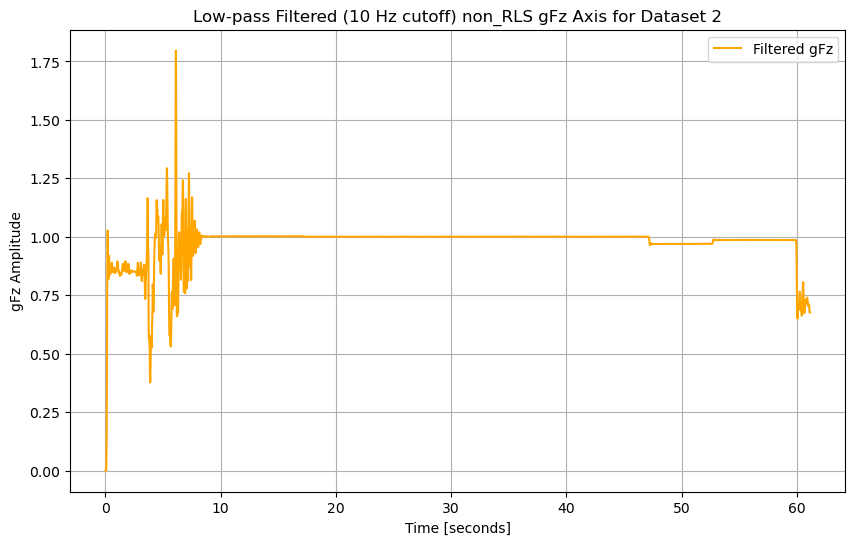

First two segments for dataset 2:
            0             1             2             3         4         5    \
0  3.887396e-10  7.538953e-09  7.267938e-08  4.664863e-07  0.000002  0.000009   
1  9.201815e-01  9.195407e-01  9.162076e-01  9.105182e-01  0.902929  0.893984   

        6         7         8         9    ...       118       119       120  \
0  0.000029  0.000082  0.000208  0.000479  ...  0.882242  0.879079  0.875621   
1  0.884268  0.874379  0.864880  0.856274  ...  0.853025  0.853586  0.853999   

        121       122       123       124       125       126       127  
0  0.872015  0.868402  0.864908  0.861642  0.858688  0.856107  0.853937  
1  0.854286  0.854483  0.854637  0.854801  0.855032  0.855384  0.855910  

[2 rows x 128 columns]


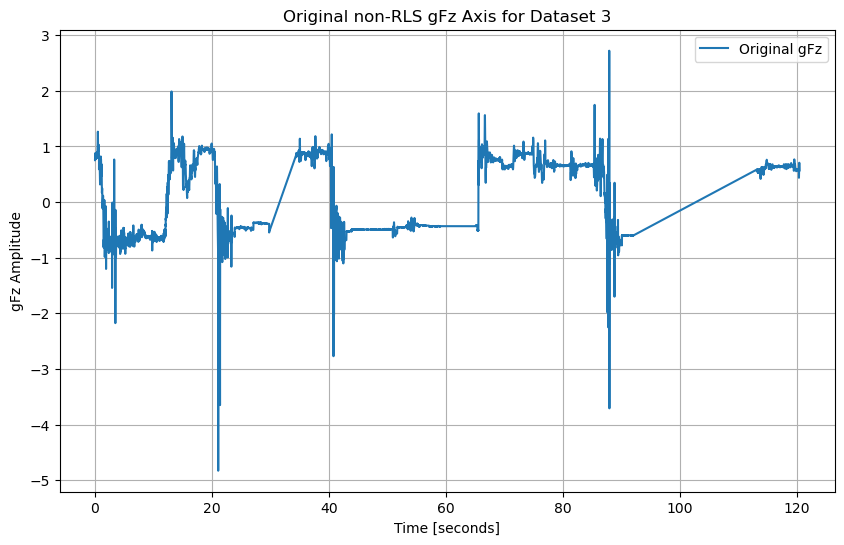

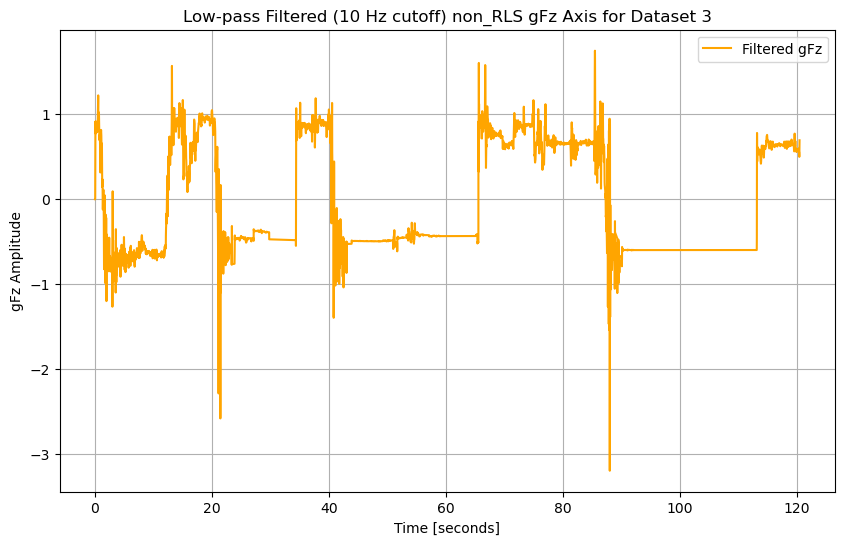

First two segments for dataset 3:
            0             1             2             3         4         5    \
0  3.512896e-10  6.811875e-09  6.566038e-08  4.213492e-07  0.000002  0.000008   
1  9.161016e-01  9.172541e-01  9.152797e-01  9.104322e-01  0.903093  0.893742   

        6         7         8         9    ...       118       119       120  \
0  0.000026  0.000074  0.000188  0.000432  ...  0.789982  0.789543  0.789002   
1  0.882923  0.871212  0.859180  0.847366  ...  0.884874  0.884227  0.883470   

        121       122       123       124       125       126       127  
0  0.788416  0.787843  0.787344  0.786979  0.786802  0.786861  0.787192  
1  0.882588  0.881564  0.880378  0.879007  0.877429  0.875618  0.873554  

[2 rows x 128 columns]


In [4]:
# Define the butterworth low-pass filter
def butter_lowpass(cutoff, fs, order=4):
    nyquist = 0.5 * fs  # Nyquist frequency
    normal_cutoff = cutoff / nyquist  # Normalize cutoff frequency
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return b, a

# Apply the filter to data
def lowpass_filter(data, cutoff, fs, order=4):
    b, a = butter_lowpass(cutoff, fs, order=order)
    y = lfilter(b, a, data)
    return y

# Segment the filtered signal
def segment_signal(data, window_size=128, overlap=64):
    segments = []
    for start in range(0, len(data) - window_size + 1, overlap):
        end = start + window_size
        segment = data[start:end]
        segments.append(segment)
    return segments

# Parameters for the filter
fs = 100       # Sampling frequency in Hz (adjust according to your data)
cutoff = 4     # Desired cutoff frequency of the filter in Hz
order = 10        # Order of the filter
window_size = 128  # Segment window size (adjust as needed)
overlap = 64     # Overlap between windows (adjust as needed)

# Create a DataFrame for segments instead of adding them to the original DataFrame
for i, file in enumerate(non_rls_files):
    datasets[f'dataset_{i+1}'] = pd.read_csv(file)
    
    # Extract columns from the current dataset
    dataset = datasets[f'dataset_{i+1}']
    time = dataset['time']
    gFz = dataset['gFz']
    
    # Apply the low-pass filter to gFz
    non_RLS_gFz_filtered = lowpass_filter(gFz, cutoff, fs, order)
    
    # Segment the filtered gFz data
    non_RLS_gFz_segments = segment_signal(non_RLS_gFz_filtered, window_size=window_size, overlap=overlap)
    
    # Convert segments to DataFrame where each row is a segment
    non_RLS_segments_df = pd.DataFrame(non_RLS_gFz_segments)
    
    # Store this DataFrame for further analysis or export
    datasets[f'dataset_{i+1}_segments'] = non_RLS_segments_df
    
   # Plot the original gFz signal in one graph
    plt.figure(figsize=(10, 6))
    plt.plot(time, gFz, label='Original gFz')
    plt.xlabel('Time [seconds]')
    plt.ylabel('gFz Amplitude')
    plt.title(f'Original non-RLS gFz Axis for Dataset {i+1}')
    plt.legend()
    plt.grid()
    plt.show()

    # Plot the filtered gFz signal in a separate graph
    plt.figure(figsize=(10, 6))
    plt.plot(time, non_RLS_gFz_filtered, label='Filtered gFz', color='orange')
    plt.xlabel('Time [seconds]')
    plt.ylabel('gFz Amplitude')
    plt.title(f'Low-pass Filtered (10 Hz cutoff) non_RLS gFz Axis for Dataset {i+1}')
    plt.legend()
    plt.grid()
    plt.show()

    # Display first few segments of the filtered data
    print(f"First two segments for dataset {i+1}:")
    print(non_RLS_segments_df.head(2))

# Low pass filter RLS dataset

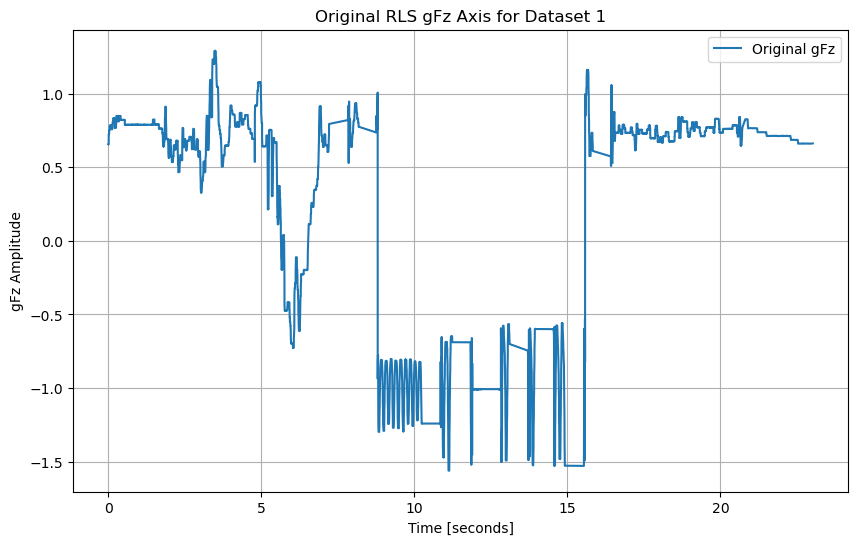

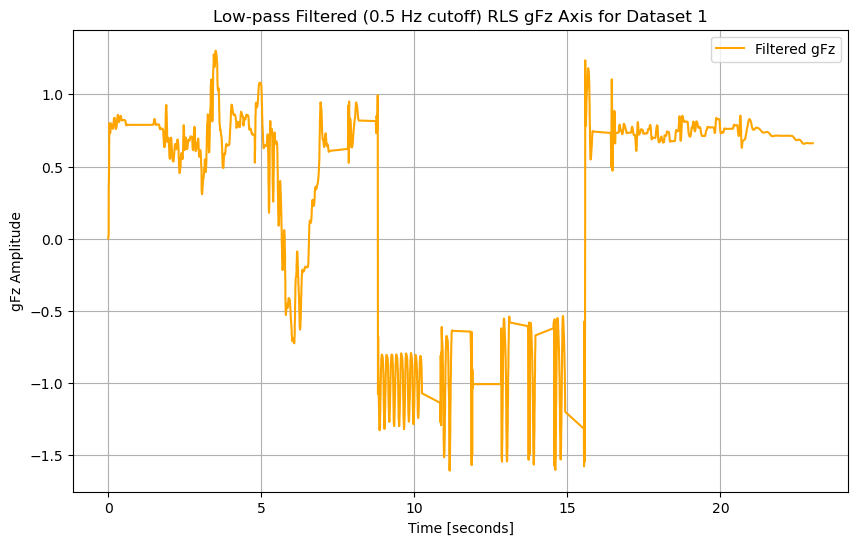

First two segments for dataset 1:
        0         1         2         3         4         5         6    \
0  0.000842  0.007556  0.032747  0.092765  0.196295  0.335641  0.488337   
1  0.789113  0.788548  0.788193  0.788134  0.788354  0.788749  0.789153   

        7         8         9    ...       246       247       248       249  \
0  0.626738  0.728894  0.785445  ...  0.789358  0.789242  0.789130  0.789030   
1  0.789406  0.789415  0.789181  ...  0.641119  0.651233  0.665409  0.685267   

        250       251       252       253       254       255  
0  0.788928  0.788820  0.788711  0.788610  0.788518  0.788439  
1  0.712805  0.748692  0.791083  0.835504  0.876004  0.907029  

[2 rows x 256 columns]


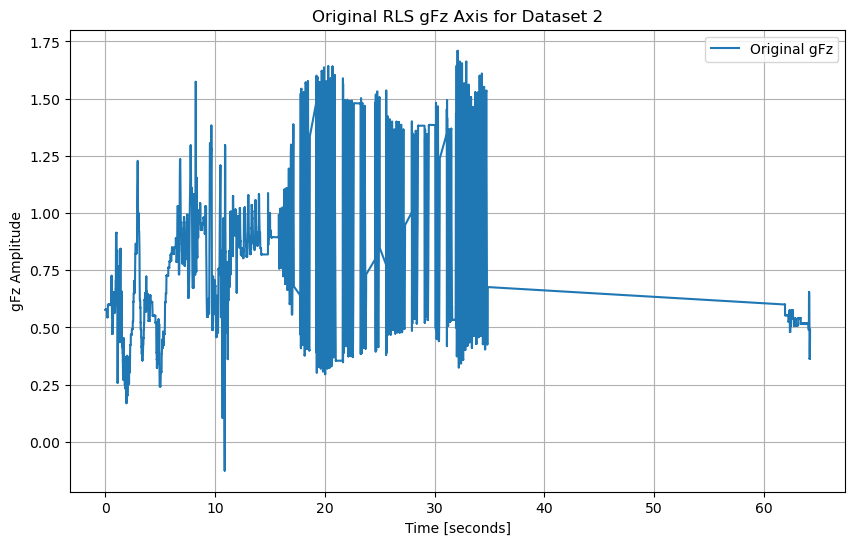

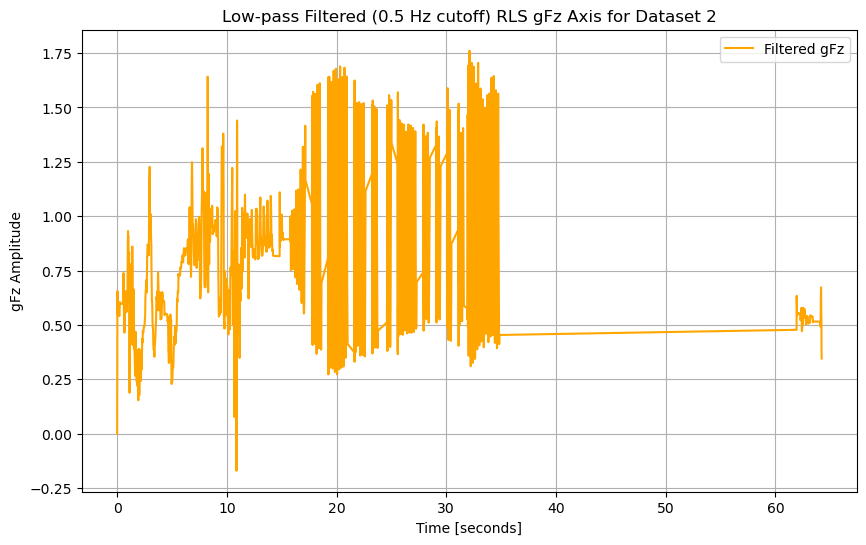

First two segments for dataset 2:
        0         1         2         3         4         5         6    \
0  0.000741  0.006650  0.028824  0.081610  0.172355  0.293511  0.424178   
1  0.578850  0.560912  0.546184  0.532792  0.519221  0.505049  0.491123   

        7         8         9    ...       246       247       248       249  \
0  0.539087  0.618717  0.655516  ...  0.722669  0.730785  0.738401  0.741361   
1  0.479035  0.470290  0.465658  ...  0.380443  0.364035  0.337014  0.303813   

        250       251       252       253       254       255  
0  0.737162  0.727139  0.716186  0.710184  0.712886  0.724258  
1  0.270351  0.242471  0.224537  0.218836  0.225339  0.241531  

[2 rows x 256 columns]


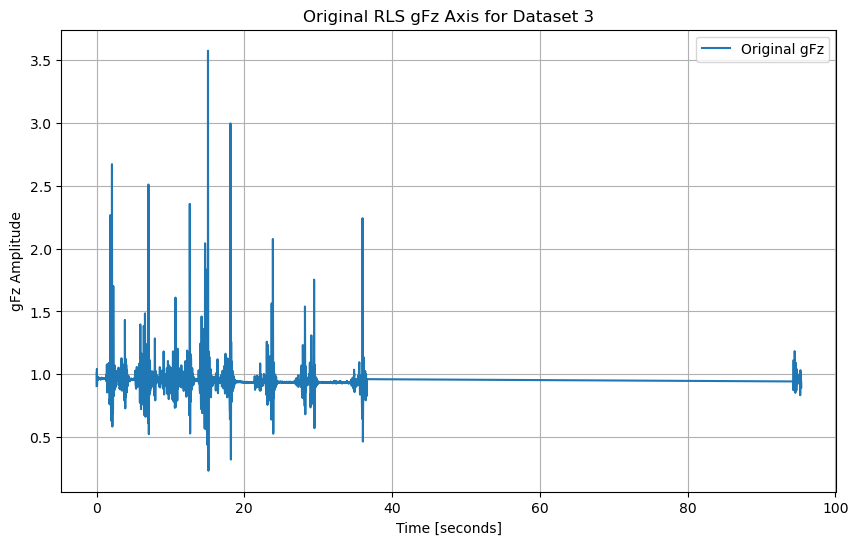

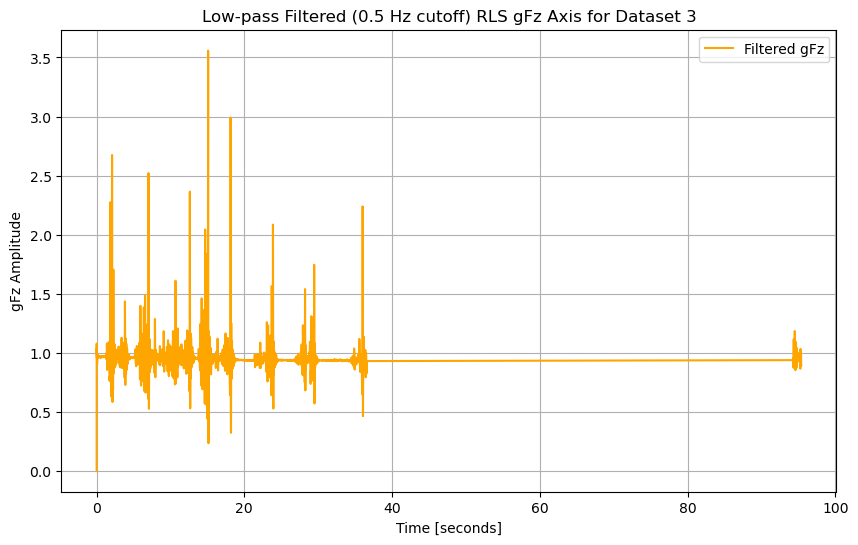

First two segments for dataset 3:
        0         1         2         3         4         5         6    \
0  0.001162  0.010440  0.045315  0.128542  0.272176  0.465092  0.675136   
1  0.971276  0.971551  0.971736  0.971800  0.971720  0.971491  0.971137   

        7         8         9    ...       246       247       248       249  \
0  0.862935  0.997638  1.066763  ...  0.962402  0.962177  0.961956  0.961796   
1  0.970688  0.970159  0.969555  ...  0.964428  0.964096  0.963936  0.963973   

        250       251       252       253       254       255  
0  0.961743  0.961816  0.962019  0.962343  0.962761  0.963224  
1  0.964169  0.964438  0.964683  0.964846  0.964924  0.964954  

[2 rows x 256 columns]


In [5]:
# Define the butterworth low-pass filter
def butter_lowpass(cutoff, fs, order=4):
    nyquist = 0.5 * fs  # Nyquist frequency
    normal_cutoff = cutoff / nyquist  # Normalize cutoff frequency
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return b, a

# Apply the filter to data
def lowpass_filter(data, cutoff, fs, order):
    b, a = butter_lowpass(cutoff, fs, order=order)
    y = lfilter(b, a, data)
    return y

# Segment the filtered signal
def segment_signal(data, window_size=128, overlap=64):
    segments = []
    for start in range(0, len(data) - window_size + 1, overlap):
        end = start + window_size
        segment = data[start:end]
        segments.append(segment)
    return segments

# Parameters for the filter
fs = 100       # Sampling frequency in Hz (adjust according to your data)
cutoff = 10     # Desired cutoff frequency of the filter in Hz
order = 5     # Order of the filter
window_size = 256  # Segment window size (adjust as needed)
overlap = 128     # Overlap between windows (adjust as needed)

# Create a DataFrame for segments instead of adding them to the original DataFrame
for i, file in enumerate(rls_files):
    datasets[f'dataset_{i+1}'] = pd.read_csv(file)
    
    # Extract columns from the current dataset
    dataset = datasets[f'dataset_{i+1}']
    time = dataset['time']
    gFz = dataset['gFz']
    
    # Apply the low-pass filter to gFz
    RLS_gFz_filtered = lowpass_filter(gFz, cutoff, fs, order)
    
    # Segment the filtered gFz data
    RLS_gFz_segments = segment_signal(RLS_gFz_filtered, window_size=window_size, overlap=overlap)
    
    # Convert segments to DataFrame where each row is a segment
    RLS_segments_df = pd.DataFrame(RLS_gFz_segments)
    
    # Store this DataFrame for further analysis or export
    datasets[f'dataset_{i+1}_segments'] = RLS_segments_df
    
   # Plot the original gFz signal in one graph
    plt.figure(figsize=(10, 6))
    plt.plot(time, gFz, label='Original gFz')
    plt.xlabel('Time [seconds]')
    plt.ylabel('gFz Amplitude')
    plt.title(f'Original RLS gFz Axis for Dataset {i+1}')
    plt.legend()
    plt.grid()
    plt.show()

    # Plot the filtered gFz signal in a separate graph
    plt.figure(figsize=(10, 6))
    plt.plot(time, RLS_gFz_filtered, label='Filtered gFz', color='orange')
    plt.xlabel('Time [seconds]')
    plt.ylabel('gFz Amplitude')
    plt.title(f'Low-pass Filtered (0.5 Hz cutoff) RLS gFz Axis for Dataset {i+1}')
    plt.legend()
    plt.grid()
    plt.show()

    # Display first few segments of the filtered data
    print(f"First two segments for dataset {i+1}:")
    print(RLS_segments_df.head(2))

# Fast Fourier Transformation of filtered RLS and non-RLS datasets

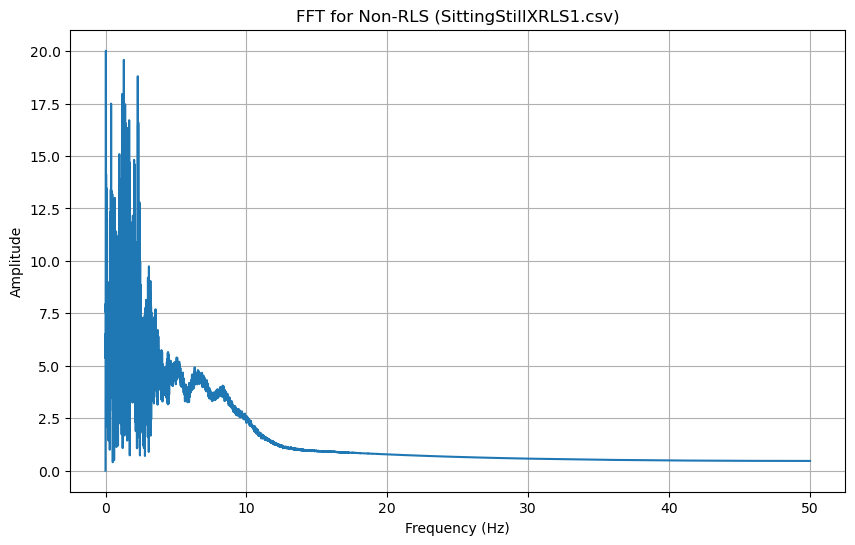

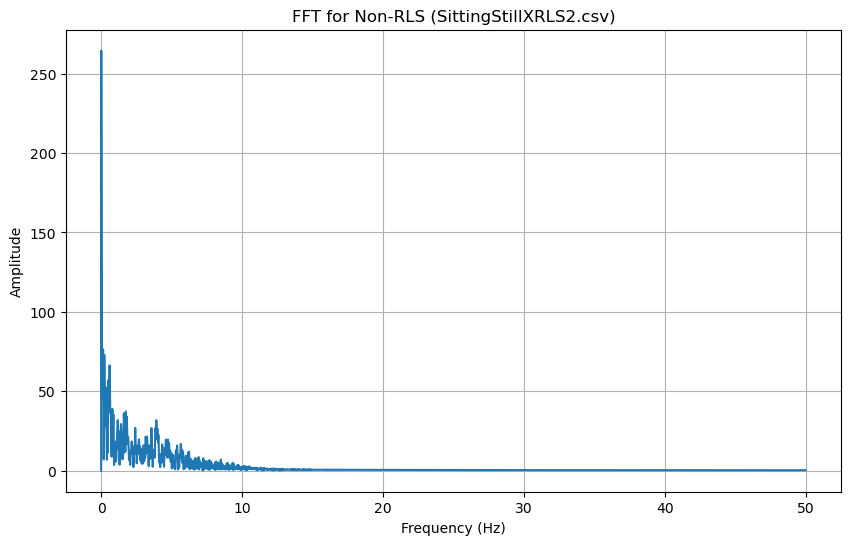

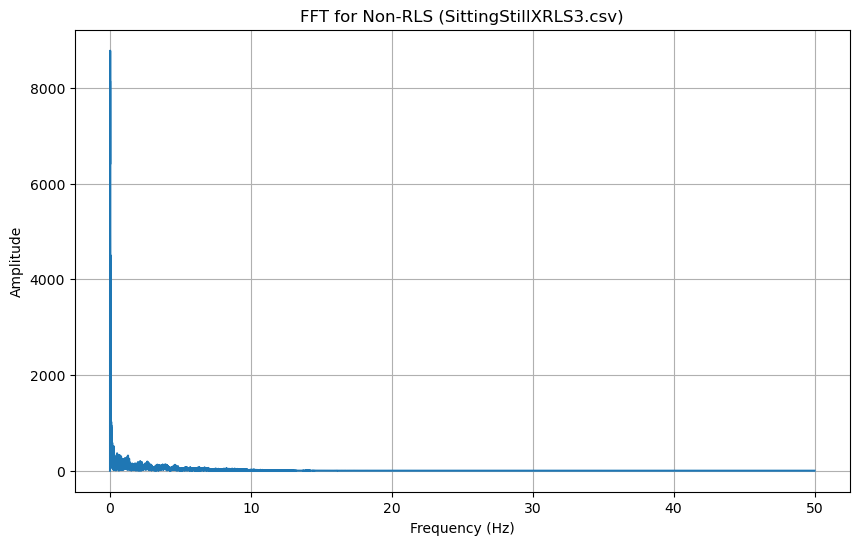

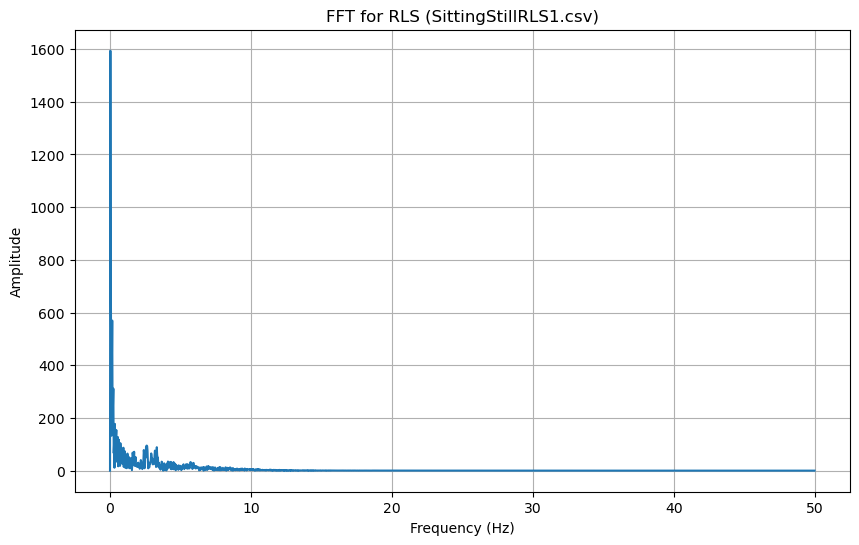

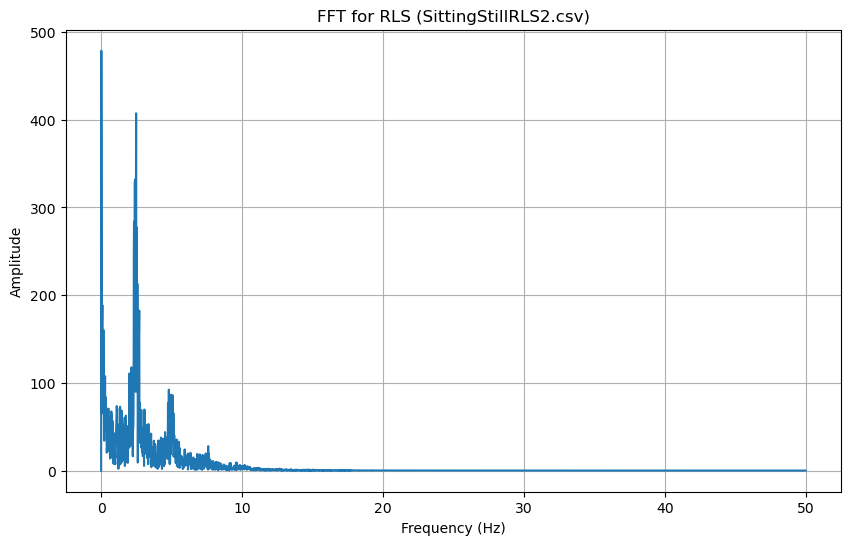

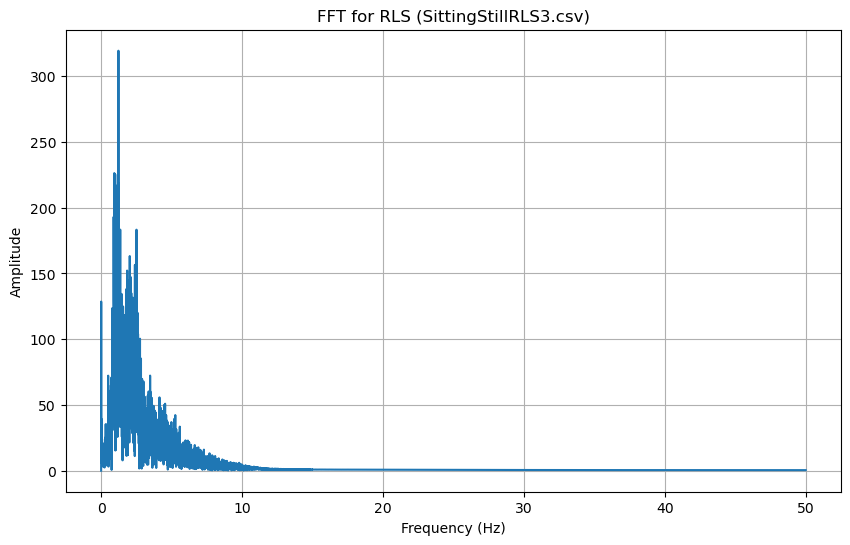

In [6]:
# Define the Butterworth low-pass filter
def butter_lowpass(cutoff, fs, order=4):
    nyquist = 0.5 * fs
    normal_cutoff = cutoff / nyquist
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return b, a

# Apply the low-pass filter
def lowpass_filter(data, cutoff, fs, order=4):
    b, a = butter_lowpass(cutoff, fs, order=order)
    y = lfilter(b, a, data)
    return y

# Plot FFT for a single dataset
def plot_fft(data, fs, title):
    data = data - np.mean(data)  # Normalize
    N = len(data)
    yf = fft(data)
    fft_magnitude = np.abs(yf[:N // 2])
    xf = np.fft.fftfreq(N, 1/fs)[:N//2]

    plt.figure(figsize=(10, 6))
    plt.plot(xf, fft_magnitude)
    plt.title(f'FFT for {title}')
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Amplitude')
    plt.grid(True)
    plt.show()

# Parameters
fs = 100       # Sampling frequency
cutoff = 10    # Cutoff frequency for the filter
order = 5      # Order of the filter

# Plot FFT for each non-RLS dataset
for file in ['SittingStillXRLS1.csv','SittingStillXRLS2.csv','SittingStillXRLS3.csv']:
    df = pd.read_csv(file)
    gFz = df['gFz'].values
    gFz_filtered = lowpass_filter(gFz, cutoff, fs, order)
    plot_fft(gFz_filtered, fs, title=f'Non-RLS ({file})')

# Plot FFT for each RLS dataset
for file in ['SittingStillRLS1.csv', 'SittingStillRLS2.csv','SittingStillRLS3.csv']:
    df = pd.read_csv(file)
    gFz = df['gFz'].values
    gFz_filtered = lowpass_filter(gFz, cutoff, fs, order)
    plot_fft(gFz_filtered, fs, title=f'RLS ({file})')


# Feature Extraction from RLS and non-RLS datasets

In [7]:
# Define the Butterworth low-pass filter
def butter_lowpass(cutoff, fs, order=4):
    nyquist = 0.5 * fs
    normal_cutoff = cutoff / nyquist
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return b, a

# Apply the low-pass filter
def lowpass_filter(data, cutoff, fs, order=4):
    b, a = butter_lowpass(cutoff, fs, order=order)
    y = lfilter(b, a, data)
    return y

# Segment the filtered signal
def segment_signal(data, window_size=128, overlap=64):
    segments = []
    for start in range(0, len(data) - window_size + 1, overlap):
        segment = data[start:start + window_size]
        segments.append(segment)
    return segments

# Feature extraction function
def extract_features(segment, fs=100.0):
    features = {}
    segment = segment - np.mean(segment)  # Normalize segment

    # Time-domain features
    features['mean'] = np.mean(segment)
    features['std'] = np.std(segment)
    features['max'] = np.max(segment)
    features['min'] = np.min(segment)
    features['range'] = np.max(segment) - np.min(segment)
    features['rms'] = np.sqrt(np.mean(segment**2))
    features['median'] = np.median(segment)
    features['skewness'] = skew(segment)
    features['kurtosis'] = kurtosis(segment)
    features['variance'] = np.var(segment)
    features['energy'] = np.sum(np.square(segment))
    features['zero_crossings'] = ((segment[:-1] * segment[1:]) < 0).sum()
    features['angular_velocity'] = np.mean(np.gradient(segment))  # Approximate angular velocity
    features['signal_magnitude_area'] = np.sum(np.abs(segment))
    features['signal_vector_magnitude'] = np.sqrt(np.sum(segment**2))
    jerk_index = np.sum(np.abs(np.diff(segment)))
    features['jerk_index'] = jerk_index
    normalized_jerk_index = jerk_index / len(segment)
    features['normalized_jerk_index'] = normalized_jerk_index
    sway_path = np.sum(np.abs(np.diff(segment)))
    features['sway_path'] = sway_path
    mean_velocity = sway_path / len(segment)
    features['mean_velocity'] = mean_velocity
    sway_area = trapz(np.abs(segment), dx=1/fs)
    features['sway_area'] = sway_area
    
    # Find peaks and calculate largest distance between them
    peaks, _ = find_peaks(segment)
    if len(peaks) > 1:
        max_peak_distance = np.max(np.diff(peaks))
    else:
        max_peak_distance = 0  # No distance if there are fewer than 2 peaks
    features['max_peak_distance'] = max_peak_distance
    
    # Frequency-domain features
    N = len(segment)
    T = 1.0 / fs
    yf = fft(segment)
    xf = np.fft.fftfreq(N, T)[:N//2]
    psd = 2.0/N * np.abs(yf[:N//2])

    fft_values = np.fft.fft(segment)
    fft_magnitude = np.abs(fft_values)
    fft_power = np.square(fft_magnitude)
    
    features['dominant_freq'] = xf[np.argmax(psd)]
    features['psd_mean'] = np.mean(psd)
    features['psd_max'] = np.max(psd)
    features['coeff_sum'] = np.sum(np.abs(yf))
    psd_entropy = entropy(psd + 1e-12)  # Adding small value to avoid log(0)
    features['psd_entropy'] = psd_entropy
    non_zero_freqs = xf[psd > 0]  # Exclude zero frequency
    frequency_dispersion = np.max(non_zero_freqs) - np.min(non_zero_freqs)
    features['frequency_dispersion'] = frequency_dispersion
    centroidal_frequency = np.sum(xf * psd) / np.sum(psd)
    features['centroidal_frequency'] = centroidal_frequency
    cumulative_power = np.cumsum(psd)
    total_power = cumulative_power[-1]
    f50 = xf[np.where(cumulative_power >= 0.5 * total_power)][0]
    features['f50'] = f50
    f95 = xf[np.where(cumulative_power >= 0.95 * total_power)][0]
    features['f95'] = f95

    return features

# Define file paths for non-RLS and RLS files
non_rls_files = ['SittingStillXRLS1.csv','SittingStillXRLS2.csv','SittingStillXRLS3.csv']
rls_files = ['SittingStillRLS1.csv', 'SittingStillRLS2.csv','SittingStillRLS3.csv']

# Parameters
fs = 100       # Sampling frequency
cutoff = 10    # Cutoff frequency for the filter
order = 5      # Order of the filter
window_size = 128  # Segment window size
overlap = 64   # Overlap between segments

# Dictionary to store datasets and features
datasets = {'non_rls': [], 'rls': []}
features_list = []

# Load, filter, segment, and extract features for non-RLS data
for file in non_rls_files:
    df = pd.read_csv(file)
    gFz = df['gFz'].values
    gFz_filtered = lowpass_filter(gFz, cutoff, fs, order)
    segments = segment_signal(gFz_filtered, window_size, overlap)
    for segment in segments:
        features = extract_features(segment, fs=fs)
        features['label'] = 0  # Label non-RLS as 0
        features_list.append(features)

# Load, filter, segment, and extract features for RLS data
for file in rls_files:
    df = pd.read_csv(file)
    gFz = df['gFz'].values
    gFz_filtered = lowpass_filter(gFz, cutoff, fs, order)
    segments = segment_signal(gFz_filtered, window_size, overlap)
    for segment in segments:
        features = extract_features(segment, fs=fs)
        features['label'] = 1  # Label RLS as 1
        features_list.append(features)
        
# Create a DataFrame from the extracted features
features_df = pd.DataFrame(features_list)
features_df.replace([np.inf, -np.inf], np.nan, inplace=True)
features_df.dropna(inplace=True)

# Display the first few rows of the DataFrame
print(features_df.head())


           mean       std       max       min     range       rms    median  \
0  2.255141e-17  0.179058  0.189075 -0.934711  1.123786  0.179058  0.032366   
1 -1.387779e-17  0.006313  0.012289 -0.012035  0.024324  0.006313 -0.000138   
2  2.602085e-18  0.004617  0.011902 -0.010486  0.022388  0.004617 -0.000372   
3  6.938894e-17  0.002497  0.004882 -0.004081  0.008964  0.002497 -0.000547   
4 -4.250073e-17  0.002503  0.004927 -0.005516  0.010443  0.002503  0.000138   

   skewness   kurtosis  variance  ...  dominant_freq  psd_mean   psd_max  \
0 -4.304292  17.873322  0.032062  ...        3.12500  0.021793  0.083303   
1  0.010632  -0.871252  0.000040  ...        3.12500  0.000350  0.005941   
2  0.397855   0.612362  0.000021  ...        3.12500  0.000271  0.004543   
3  0.347578  -0.853675  0.000006  ...        0.78125  0.000144  0.002346   
4 -0.160661  -0.417726  0.000006  ...        2.34375  0.000147  0.002350   

    coeff_sum  psd_entropy  frequency_dispersion  centroidal_frequen

# Checking null values

In [3]:
# File paths
non_rls_files = ['Khaliq3.csv', 'Inessa.csv', 'Naimah.csv']
rls_files = ['Arif2.csv', 'Faris.csv', 'Auni2.csv']

# Function to check null values in a file
def check_null_values(file_list):
    for file in file_list:
        try:
            data = pd.read_csv(file)  # Load the CSV file
            null_counts = data.isnull().sum().sum()  # Total null values
            print(f"File: {file} - Null Values: {null_counts}")
        except Exception as e:
            print(f"Error reading file {file}: {e}")

# Check null values in non-RLS and RLS files
print("Checking Non-RLS Files:")
check_null_values(non_rls_files)

print("\nChecking RLS Files:")
check_null_values(rls_files)


Checking Non-RLS Files:
File: Khaliq3.csv - Null Values: 0
File: Inessa.csv - Null Values: 0
File: Naimah.csv - Null Values: 0

Checking RLS Files:
File: Arif2.csv - Null Values: 0
File: Faris.csv - Null Values: 0
File: Auni2.csv - Null Values: 0


# Summary statistics of features

In [41]:
# Create a DataFrame from the features list
features_df = pd.DataFrame(features_list)

# Basic information about the dataset
print("Summary statistics for all features:\n")
print(features_df.describe())
print("\nCount of RLS and non-RLS segments:\n")
print(features_df['label'].value_counts())


Summary statistics for all features:

               mean          std          max          min        range  \
count  1.558000e+03  1558.000000  1558.000000  1558.000000  1558.000000   
mean   1.143631e-18     0.073187     0.149368    -0.131976     0.281344   
std    6.220293e-17     0.127916     0.289650     0.283106     0.526254   
min   -2.220446e-16     0.000196     0.000357    -3.796424     0.000752   
25%   -3.816392e-17     0.001940     0.004022    -0.139300     0.007739   
50%    3.469447e-18     0.018508     0.034380    -0.032794     0.068372   
75%    3.816392e-17     0.081931     0.155016    -0.003831     0.308105   
max    2.194425e-16     1.157955     3.017788    -0.000378     5.962584   

               rms       median     skewness     kurtosis      variance  ...  \
count  1558.000000  1558.000000  1558.000000  1558.000000  1.558000e+03  ...   
mean      0.073187    -0.006471     0.089799    -0.014269  2.170833e-02  ...   
std       0.127916     0.041716     0.802083  

# Histogram plots of features

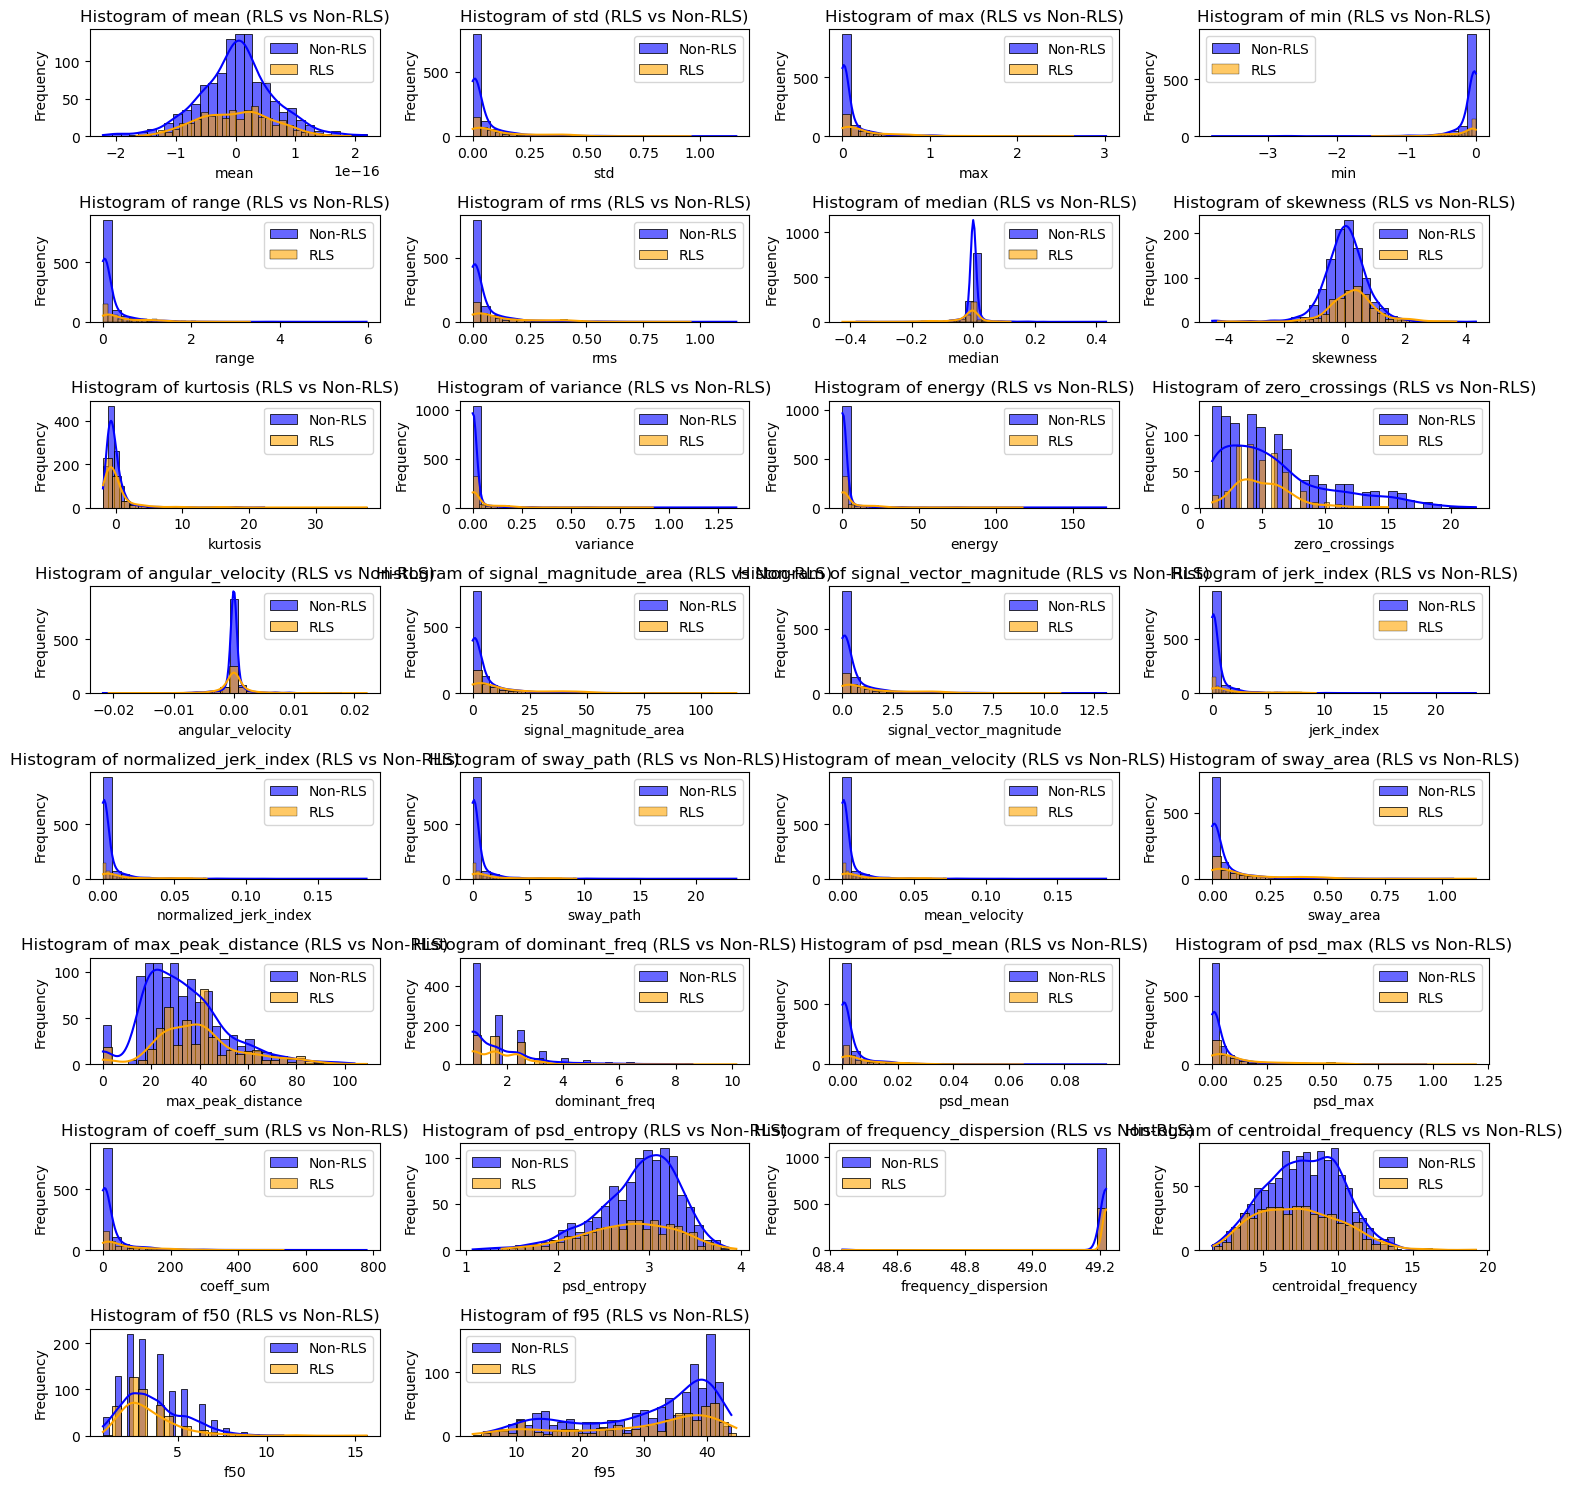

In [4]:
# Histogram to check skewness
plt.figure(figsize=(15, 15))
num_features = len(features_df.columns) - 1  # Exclude the label column
rows = (num_features // 5) + 1
for i, feature in enumerate(features_df.columns[:-1], 1):  # Exclude the label column
    plt.subplot(8,4,i)
    sns.histplot(features_df[features_df['label'] == 0][feature], color='blue', label='Non-RLS', kde=True, bins=30, alpha=0.6)
    sns.histplot(features_df[features_df['label'] == 1][feature], color='orange', label='RLS', kde=True, bins=30, alpha=0.6)
    plt.title(f'Histogram of {feature} (RLS vs Non-RLS)')
    plt.xlabel(feature)
    plt.ylabel('Frequency')
    plt.legend()

plt.tight_layout()
plt.show()

# Boxplots of features

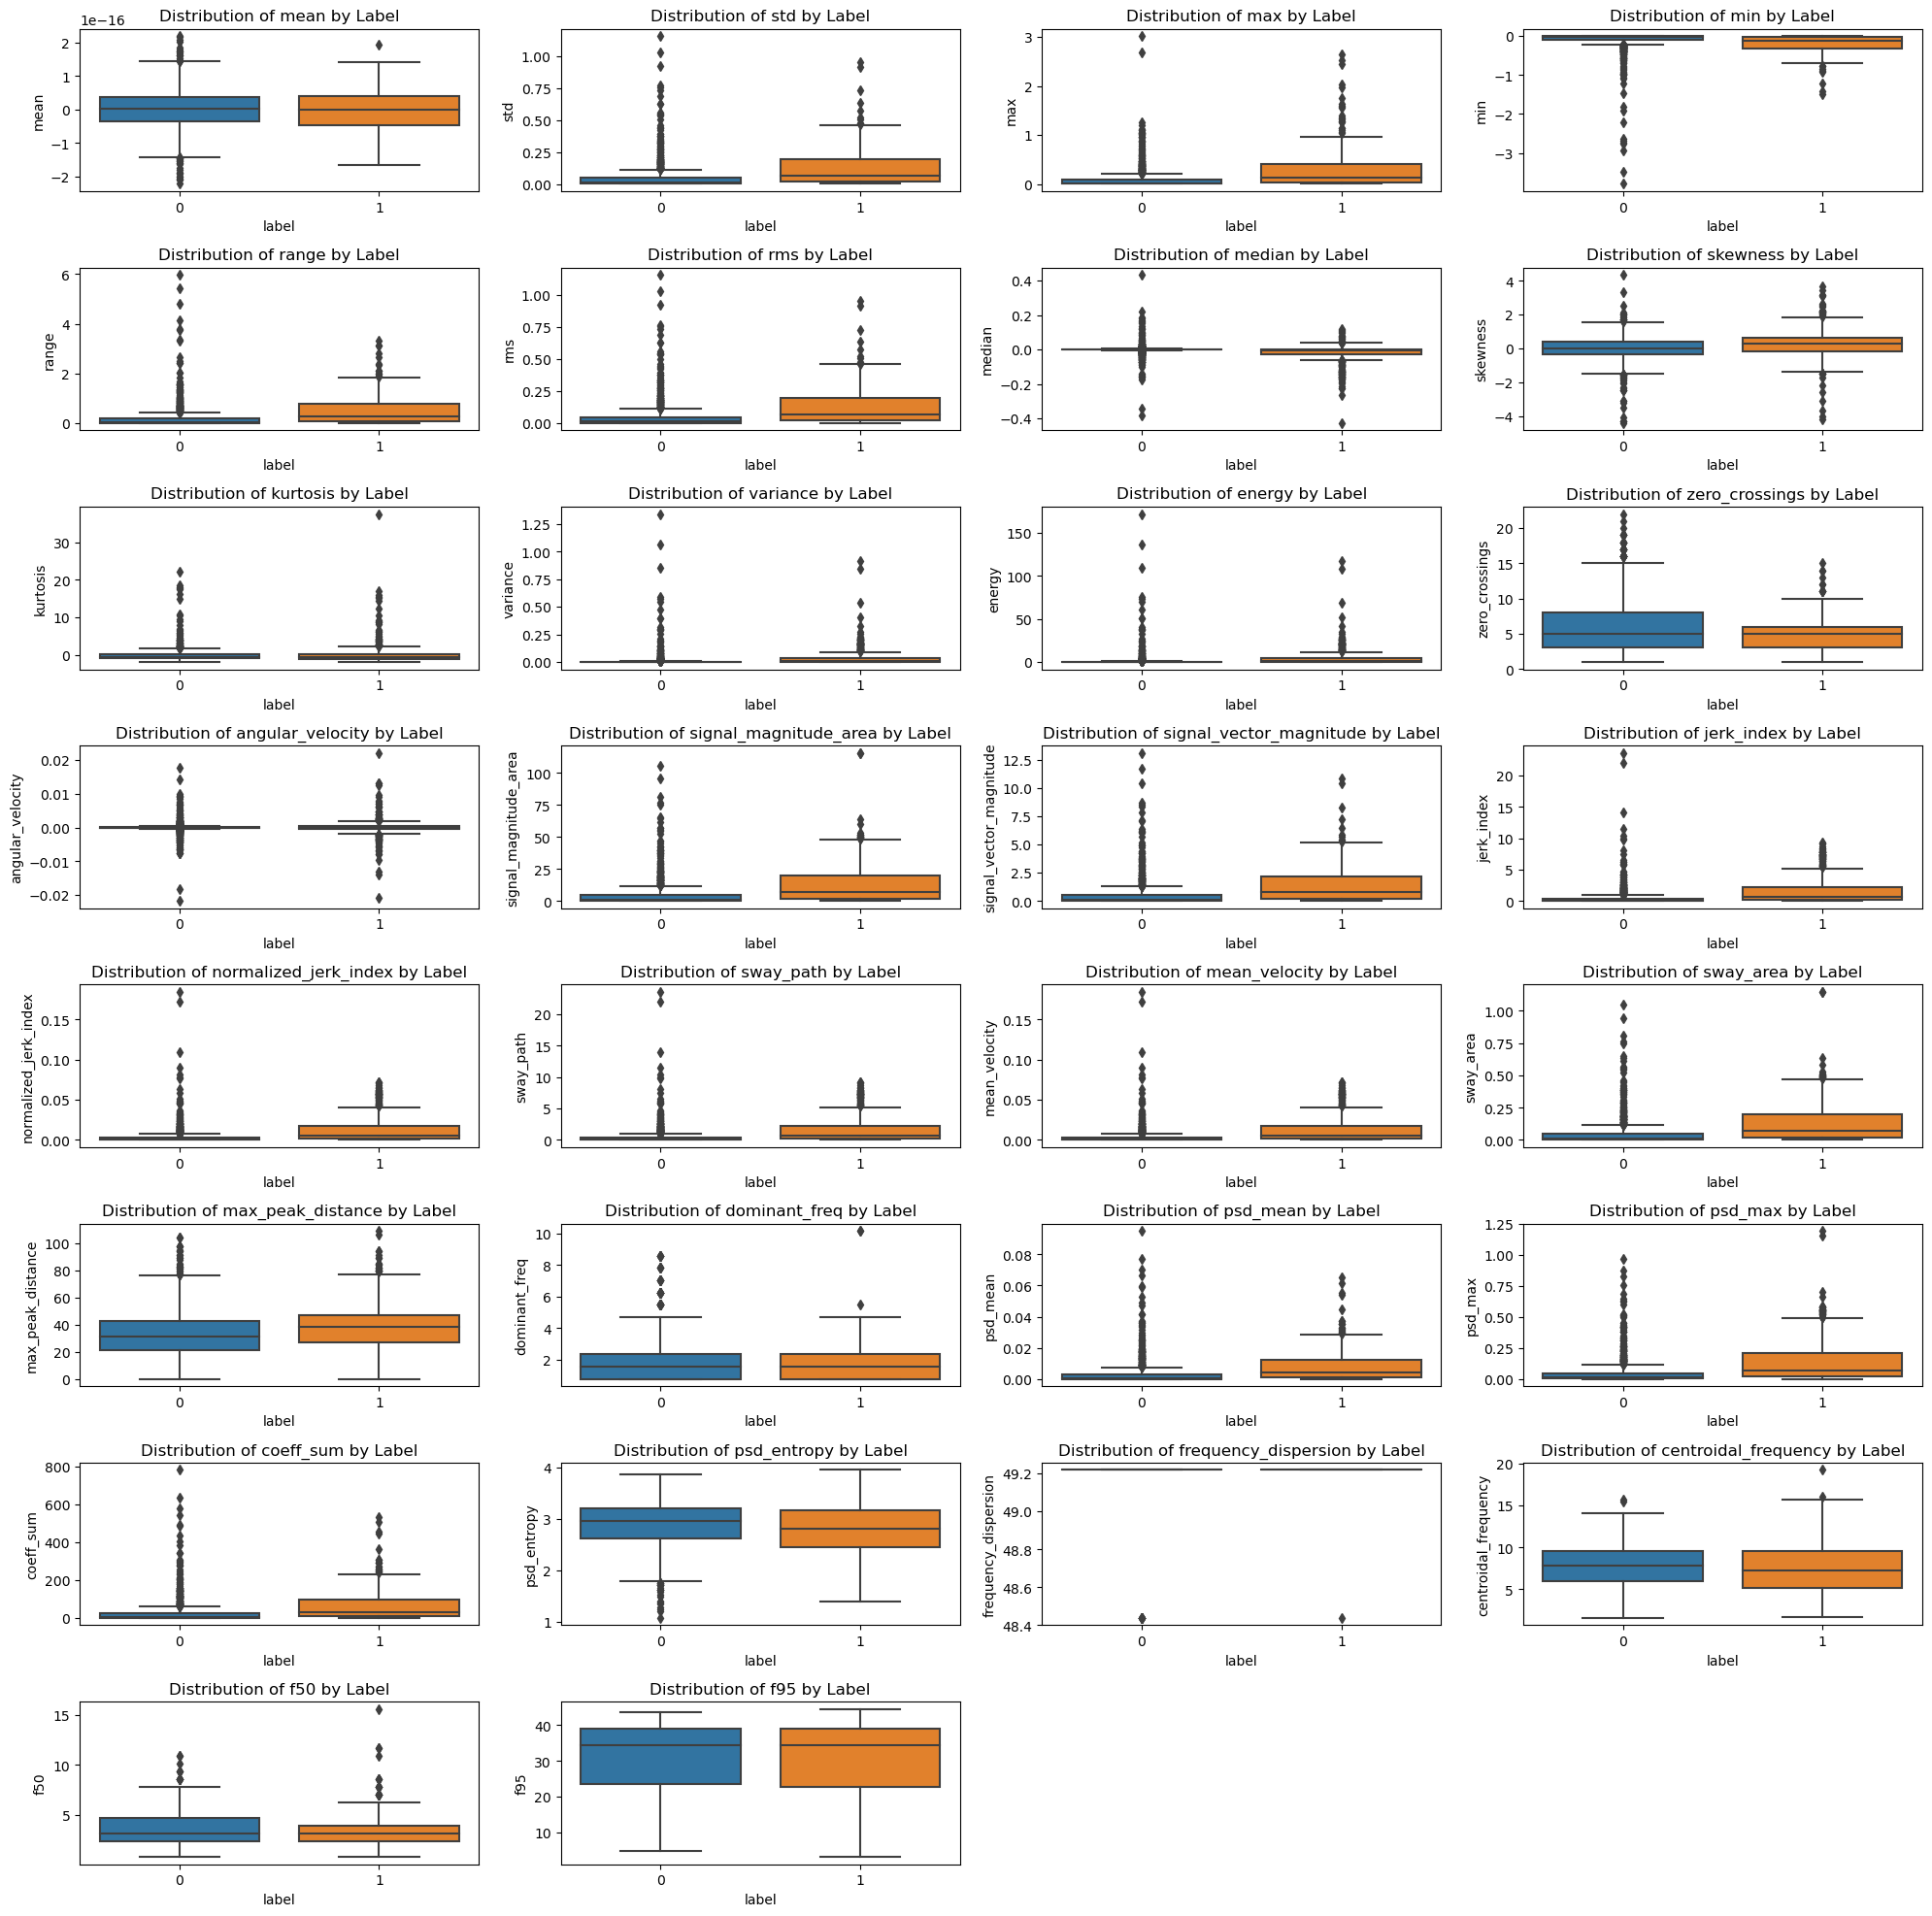

In [43]:
# Boxplots to compare feature distributions for RLS vs. non-RLS
plt.figure(figsize=(20,20))
for i, feature in enumerate(features_df.columns[:-1], 1):  # Exclude the label column
    plt.subplot(8, 4, i)
    sns.boxplot(x='label', y=feature, data=features_df)
    plt.title(f'Distribution of {feature} by Label')
plt.tight_layout()
plt.show()

# Plots after Box-cox transformation and Z-score normalization

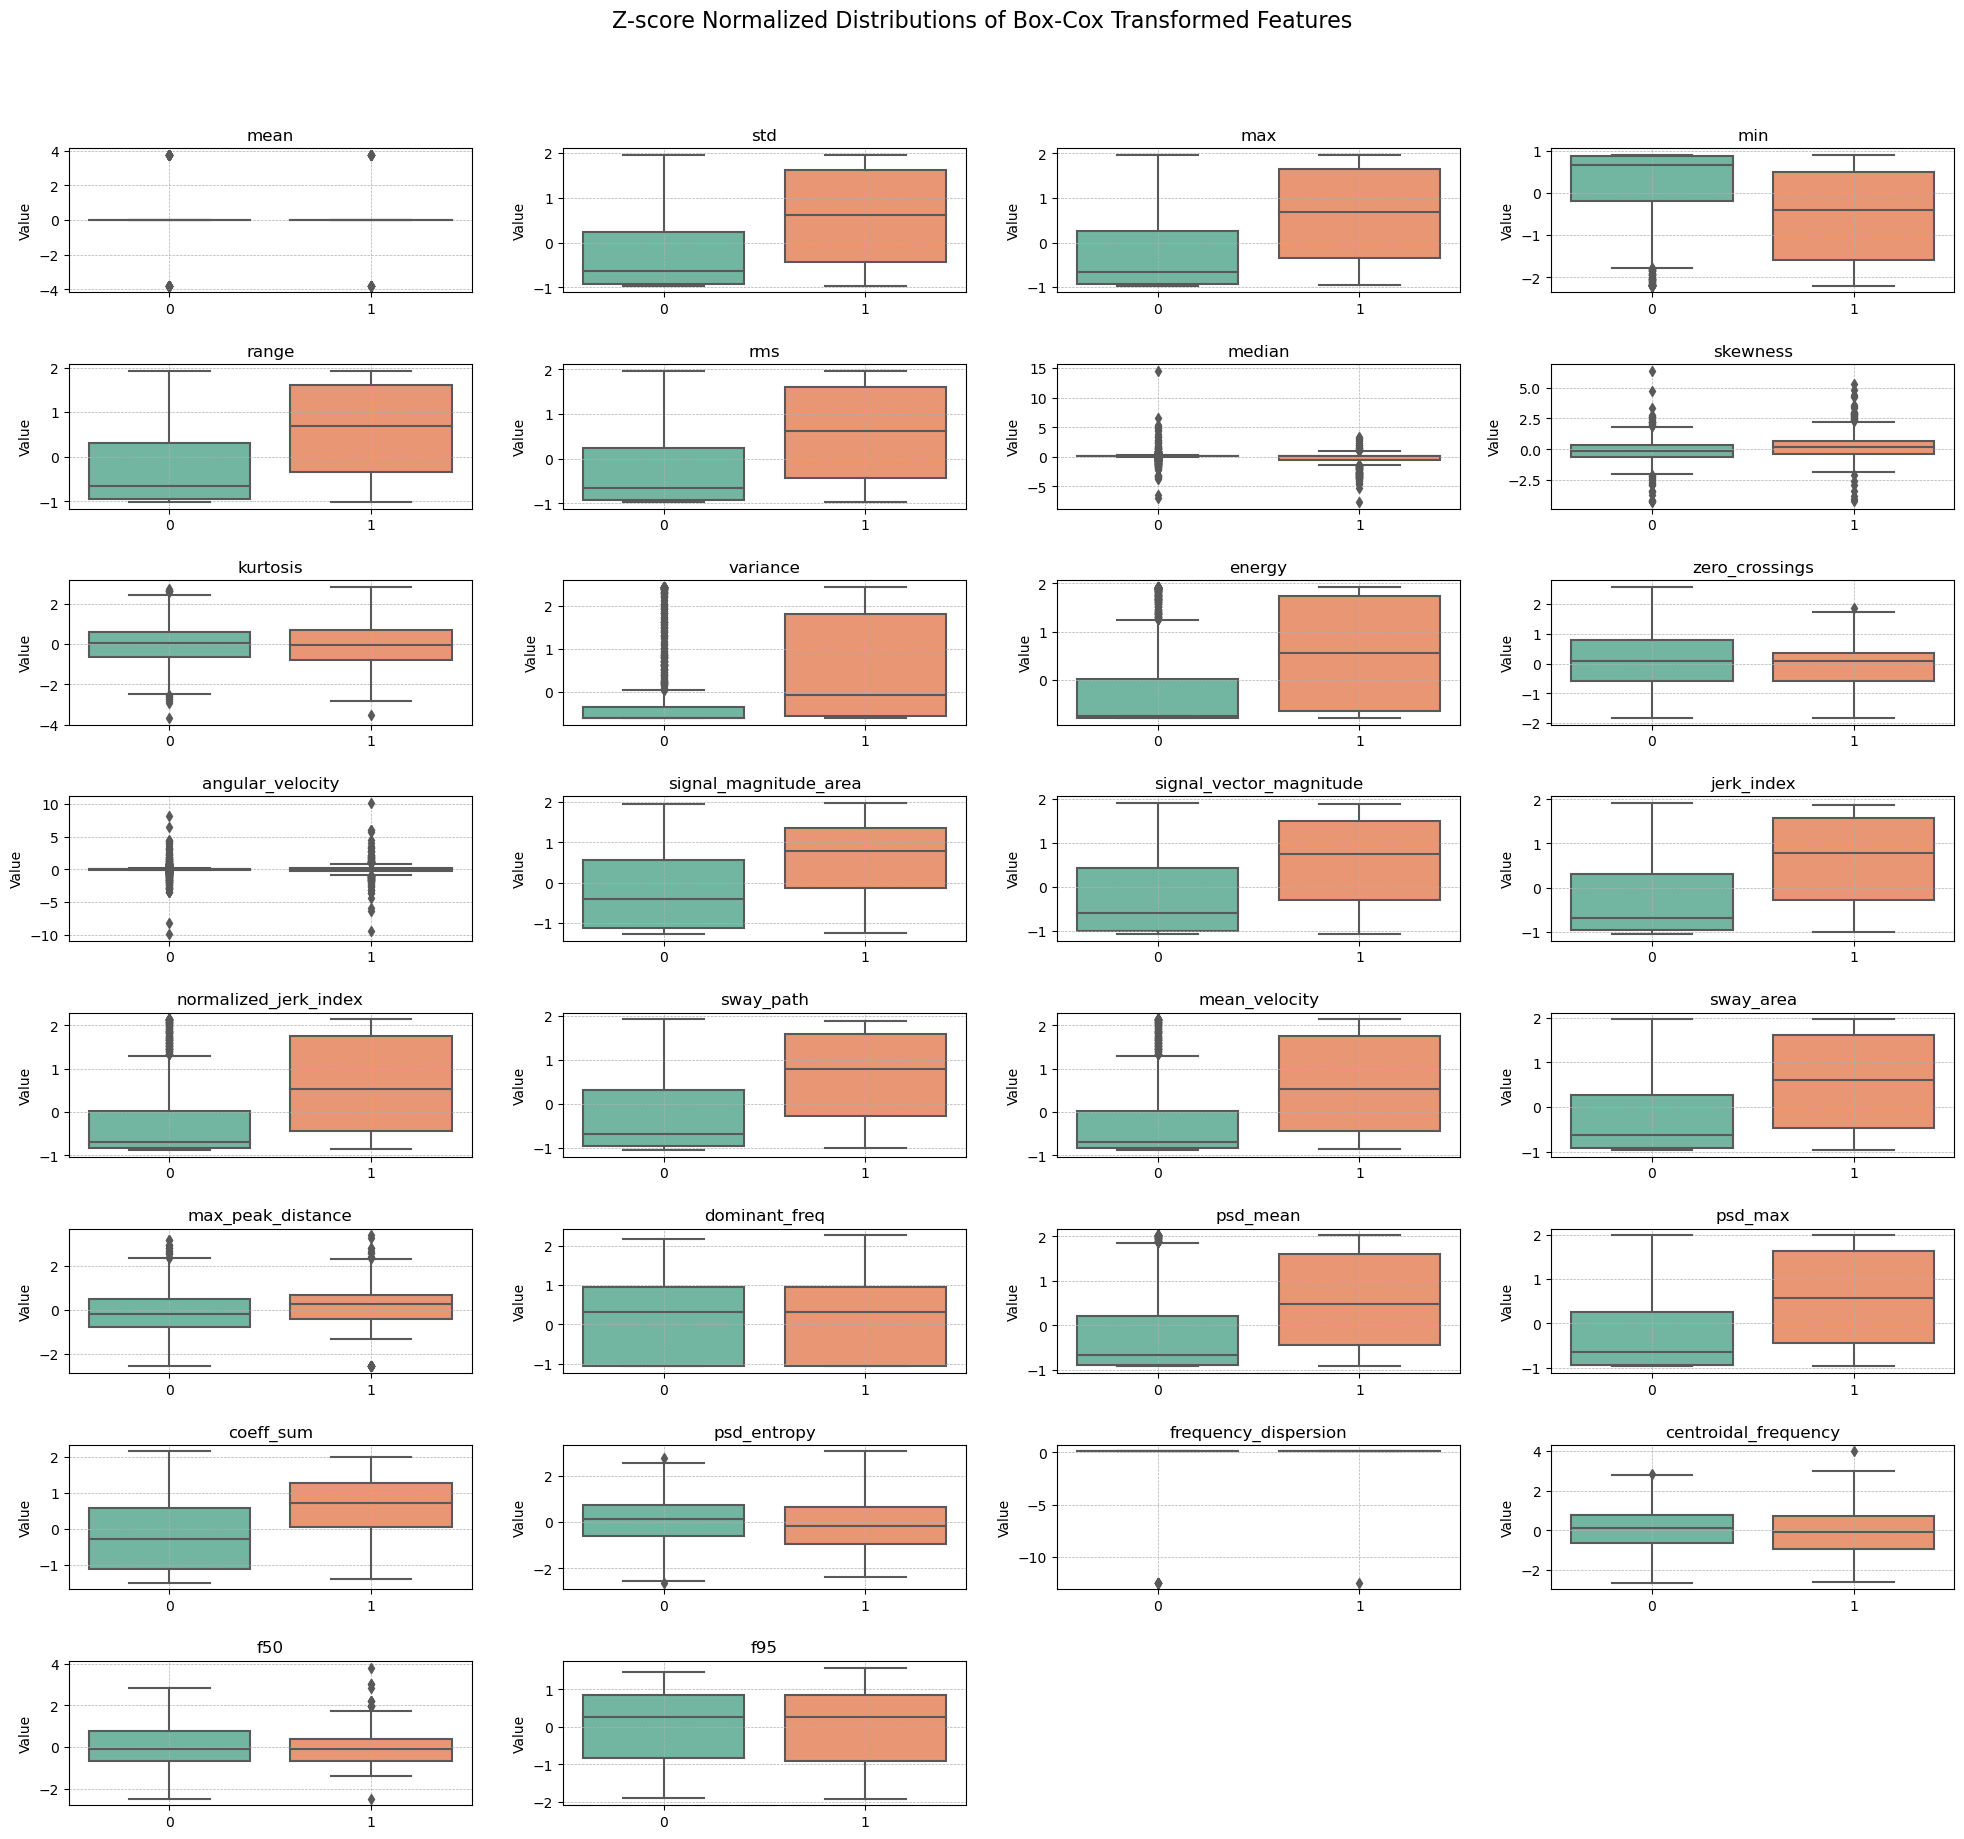

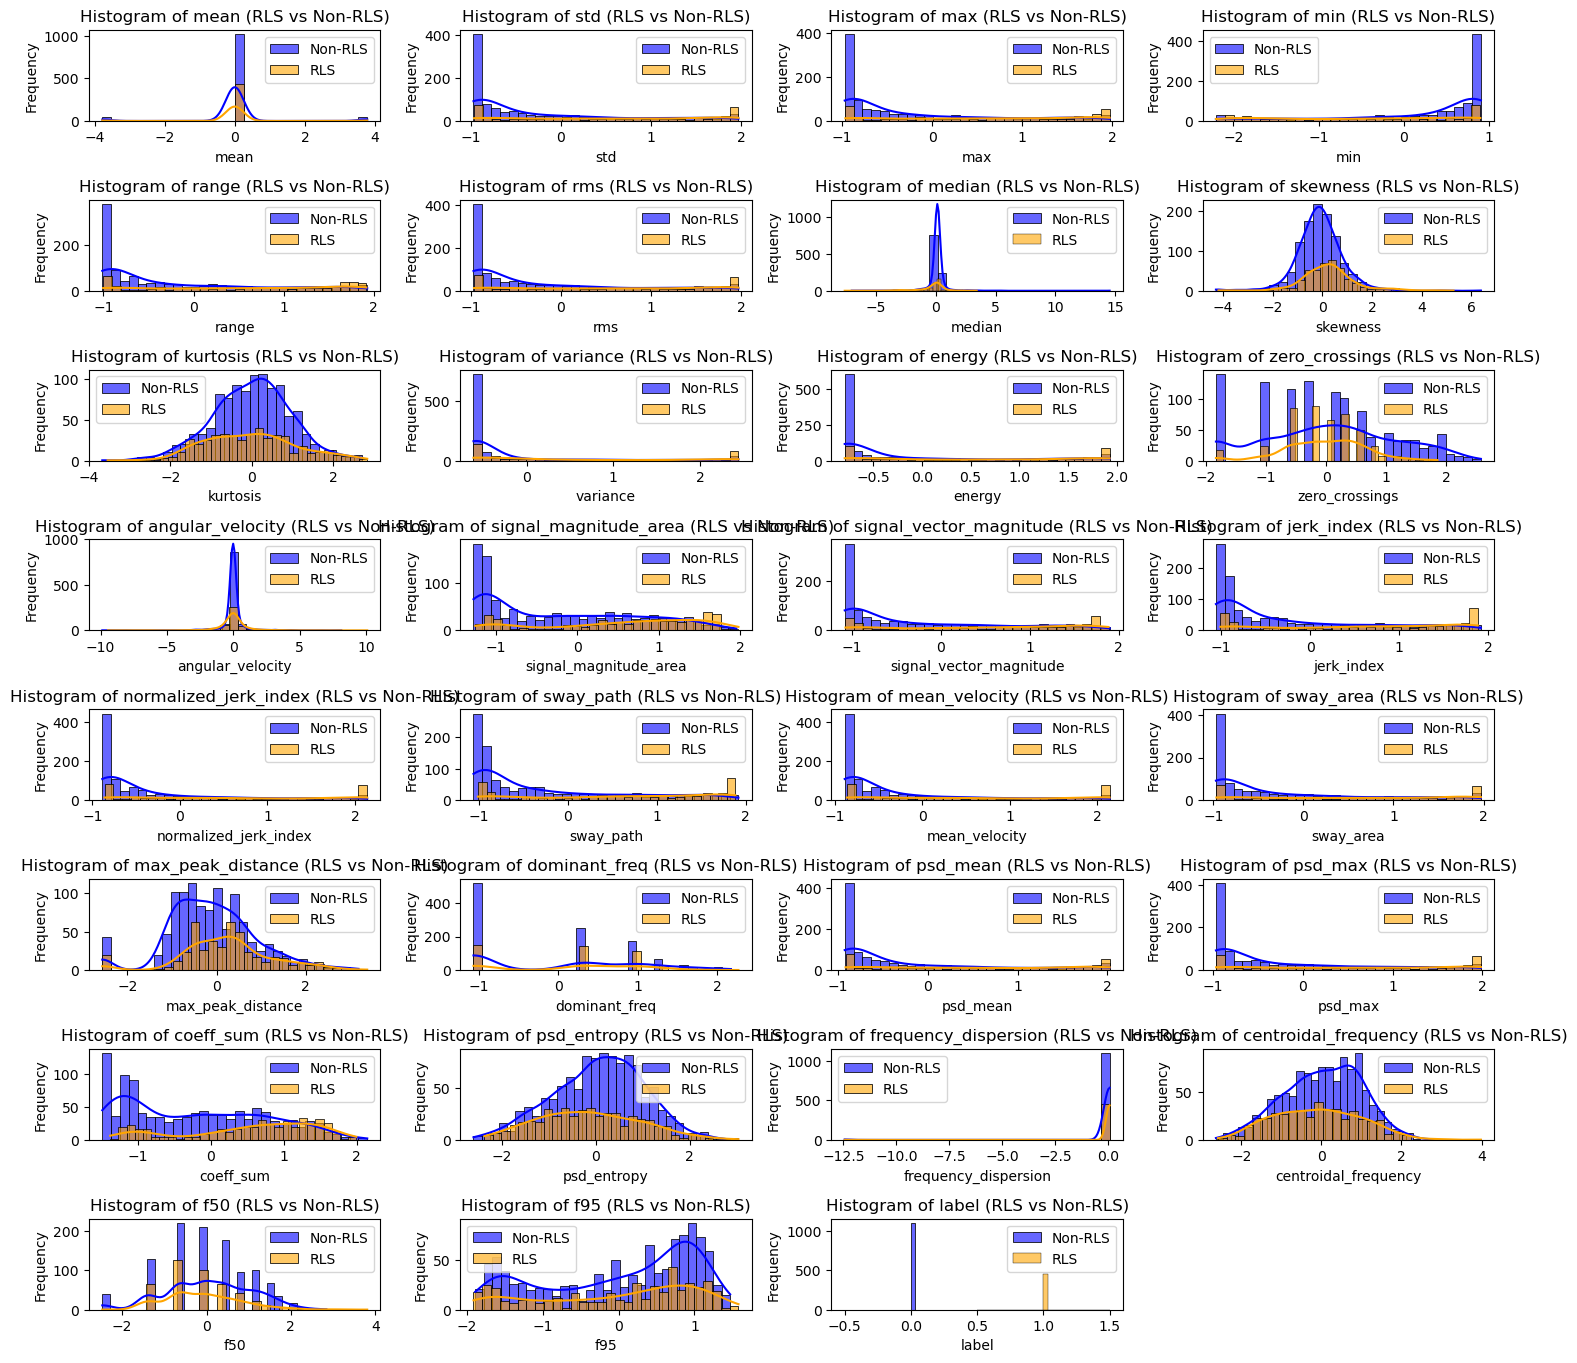

In [5]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, PowerTransformer

# Separate features and labels
X = features_df.drop(columns=['label'])
y = features_df['label']

# Ensure all features are positive for Box-Cox
X = X.copy()
for col in X.columns:
    X[col] = X[col] - X[col].min() + 1  # Shift to make all values positive

# 2. Box-Cox Transformation
box_cox_transformer = PowerTransformer(method='box-cox')  # Initialize Box-Cox transformer
X_box_cox = box_cox_transformer.fit_transform(X)  # Apply Box-Cox transformation

# 3. Z-score Normalization after Box-Cox Transformation
scaler = StandardScaler()
X_box_cox_zscore = scaler.fit_transform(X_box_cox)
features_df_box_cox_zscore = pd.DataFrame(X_box_cox_zscore, columns=X.columns)
features_df_box_cox_zscore['label'] = y

# Visualizing the distributions after Box-Cox Transformation and Z-score Normalization
plt.figure(figsize=(20, 20))
num_features = len(features_df_box_cox_zscore.columns[:-1])  # Number of features (exclude 'label')
rows = (num_features // 5) + 1

for i, feature in enumerate(features_df_box_cox_zscore.columns[:-1], 1):
    plt.subplot(9, 4, i)
    sns.boxplot(x='label', y=feature, data=features_df_box_cox_zscore, palette='Set2')
    plt.title(f'{feature}', fontsize=12)
    plt.xlabel('')
    plt.ylabel('Value', fontsize=10)
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)

plt.suptitle('Z-score Normalized Distributions of Box-Cox Transformed Features', fontsize=16, y=1.02)
plt.tight_layout(pad=2.0)
plt.show()

plt.figure(figsize=(15, 15))
num_features = len(features_df_box_cox_zscore.columns) - 1  # Exclude the label column
rows = (num_features // 5) + 1
for i, feature in enumerate(features_df_box_cox_zscore[:-1], 1):  # Exclude the label column
    plt.subplot(9,4,i)
    sns.histplot(features_df_box_cox_zscore[features_df_box_cox_zscore['label'] == 0][feature], color='blue', label='Non-RLS', kde=True, bins=30, alpha=0.6)
    sns.histplot(features_df_box_cox_zscore[features_df_box_cox_zscore['label'] == 1][feature], color='orange', label='RLS', kde=True, bins=30, alpha=0.6)
    plt.title(f'Histogram of {feature} (RLS vs Non-RLS)')
    plt.xlabel(feature)
    plt.ylabel('Frequency')
    plt.legend()

plt.tight_layout()
plt.show()



# Principal Component Analysis

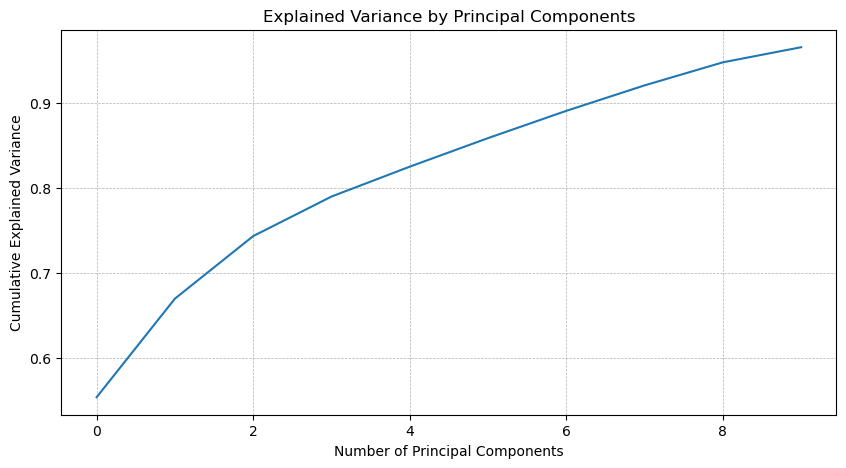

Number of components chosen to retain 95.0% of variance: 10


In [45]:
from sklearn.decomposition import PCA

# Specify the desired amount of variance to retain (e.g., 95%)
variance_threshold = 0.95

# Initialize PCA
pca = PCA(n_components=variance_threshold)

# Fit PCA on the normalized data (excluding the label column)
X_pca = pca.fit_transform(features_df_box_cox_zscore.drop(columns=['label']))

# Create a DataFrame for the PCA-transformed data
pca_columns = [f'PC{i+1}' for i in range(X_pca.shape[1])]
features_df_pca = pd.DataFrame(X_pca, columns=pca_columns)
features_df_pca['label'] = features_df_box_cox_zscore['label']

# Explained variance ratio of each principal component
explained_variance_ratio = pca.explained_variance_ratio_

# Plot the explained variance ratio
plt.figure(figsize=(10, 5))
plt.plot(np.cumsum(explained_variance_ratio))
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance by Principal Components')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.show()

# Print the number of components chosen to capture the desired variance
print(f"Number of components chosen to retain {variance_threshold*100:.1f}% of variance: {pca.n_components_}")


# Feature selection via random forest classifier

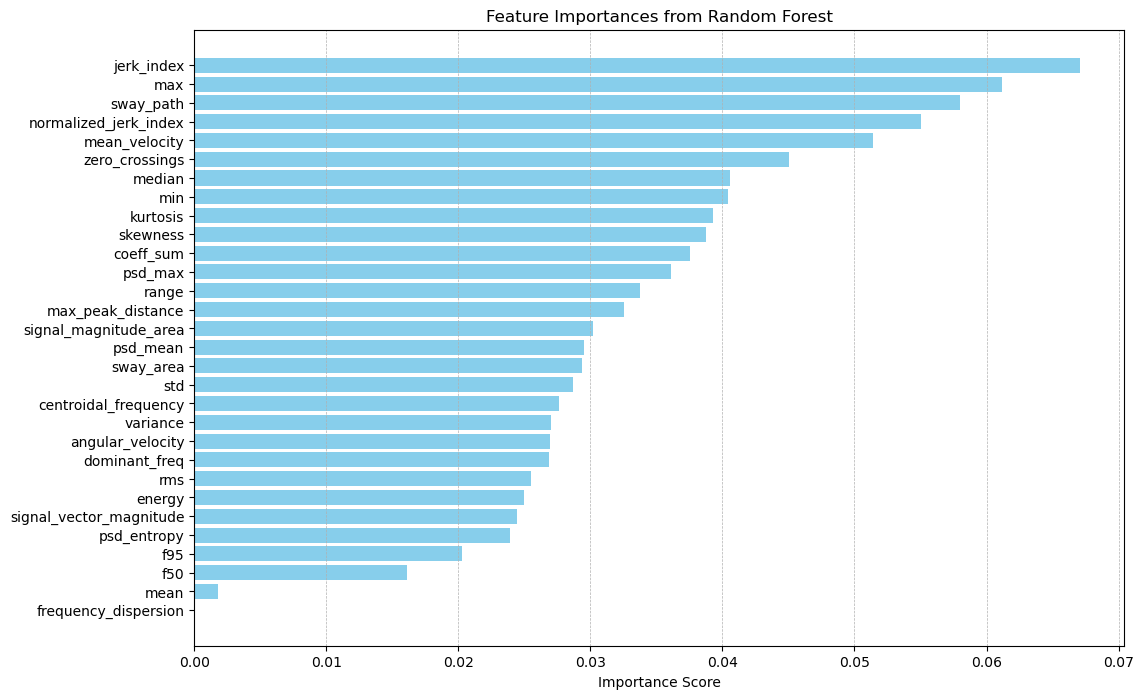

Top Important Features:
                  Feature  Importance
15             jerk_index    0.067075
2                     max    0.061202
17              sway_path    0.058028
16  normalized_jerk_index    0.055045
18          mean_velocity    0.051401
11         zero_crossings    0.045029
6                  median    0.040610
3                     min    0.040410
8                kurtosis    0.039282
7                skewness    0.038727


In [46]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFE
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split

# Ensure X and y are the same as those used for training
X = features_df_box_cox_zscore.drop(columns=['label'])
y = features_df_box_cox_zscore['label']

# Train-test split (if needed)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)

# Initialize and train a Random Forest model
model = RandomForestClassifier(class_weight='balanced', random_state=42)
model.fit(X_train, y_train)

# Feature importances
importances = model.feature_importances_

# Create a DataFrame for visualization (ensure the length matches)
feature_importances_df = pd.DataFrame({
    'Feature': X_train.columns,  # Use X_train columns for consistency
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# Plot feature importances
plt.figure(figsize=(12, 8))
plt.barh(feature_importances_df['Feature'], feature_importances_df['Importance'], color='skyblue')
plt.xlabel('Importance Score')
plt.title('Feature Importances from Random Forest')
plt.gca().invert_yaxis()  # To show the highest importance on top
plt.grid(axis='x', linestyle='--', linewidth=0.5)
plt.show()

# Print the top N important features
print("Top Important Features:")
print(feature_importances_df.head(10))



# Correlation Matrix

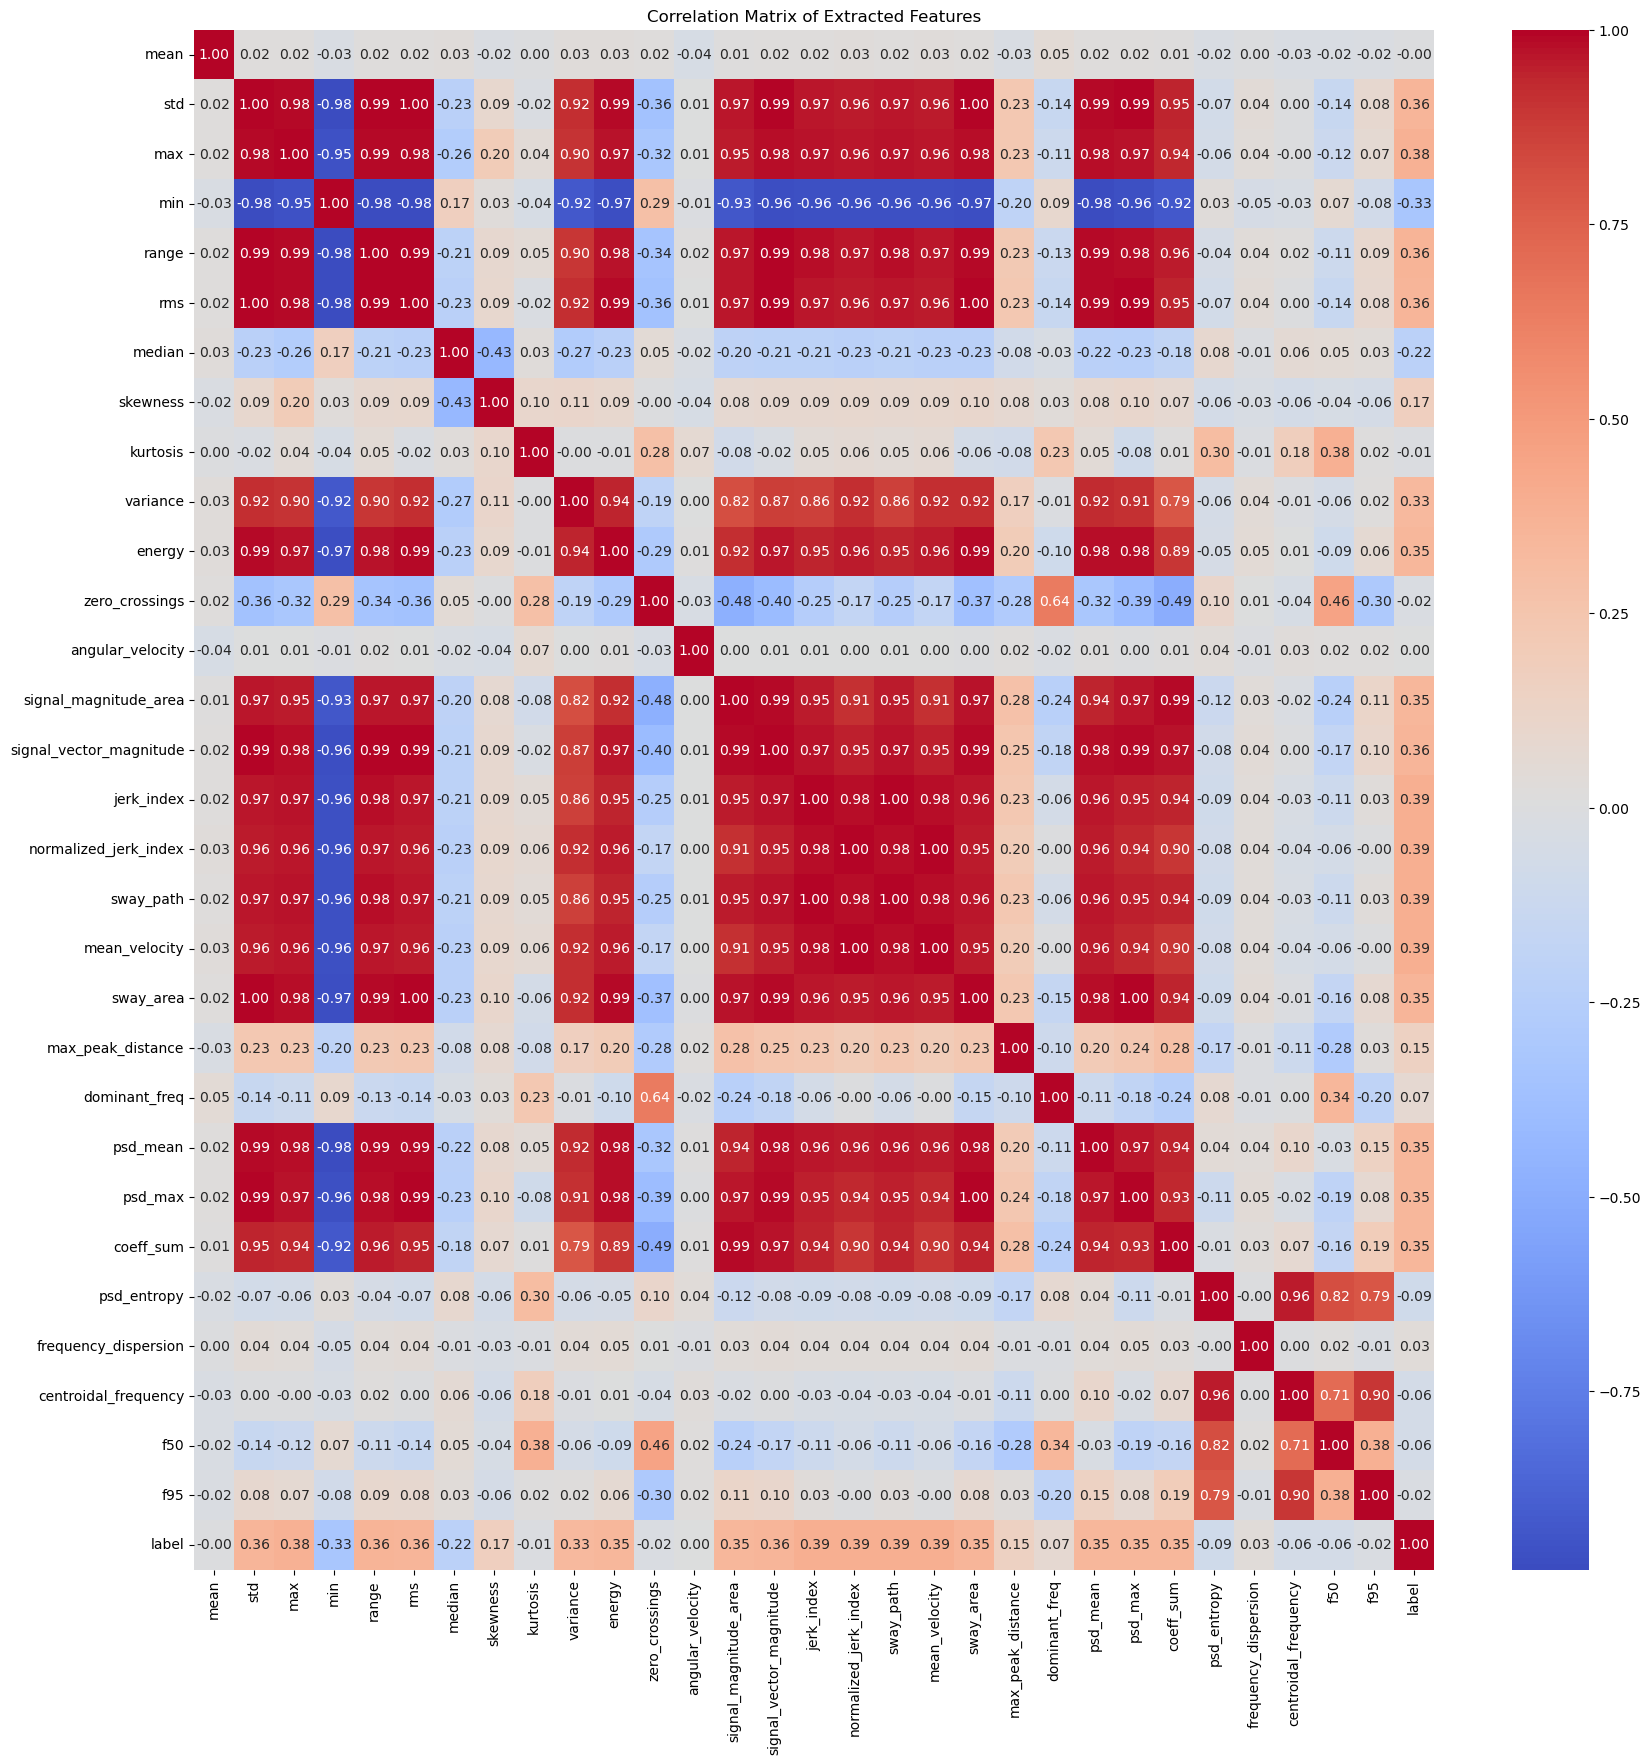

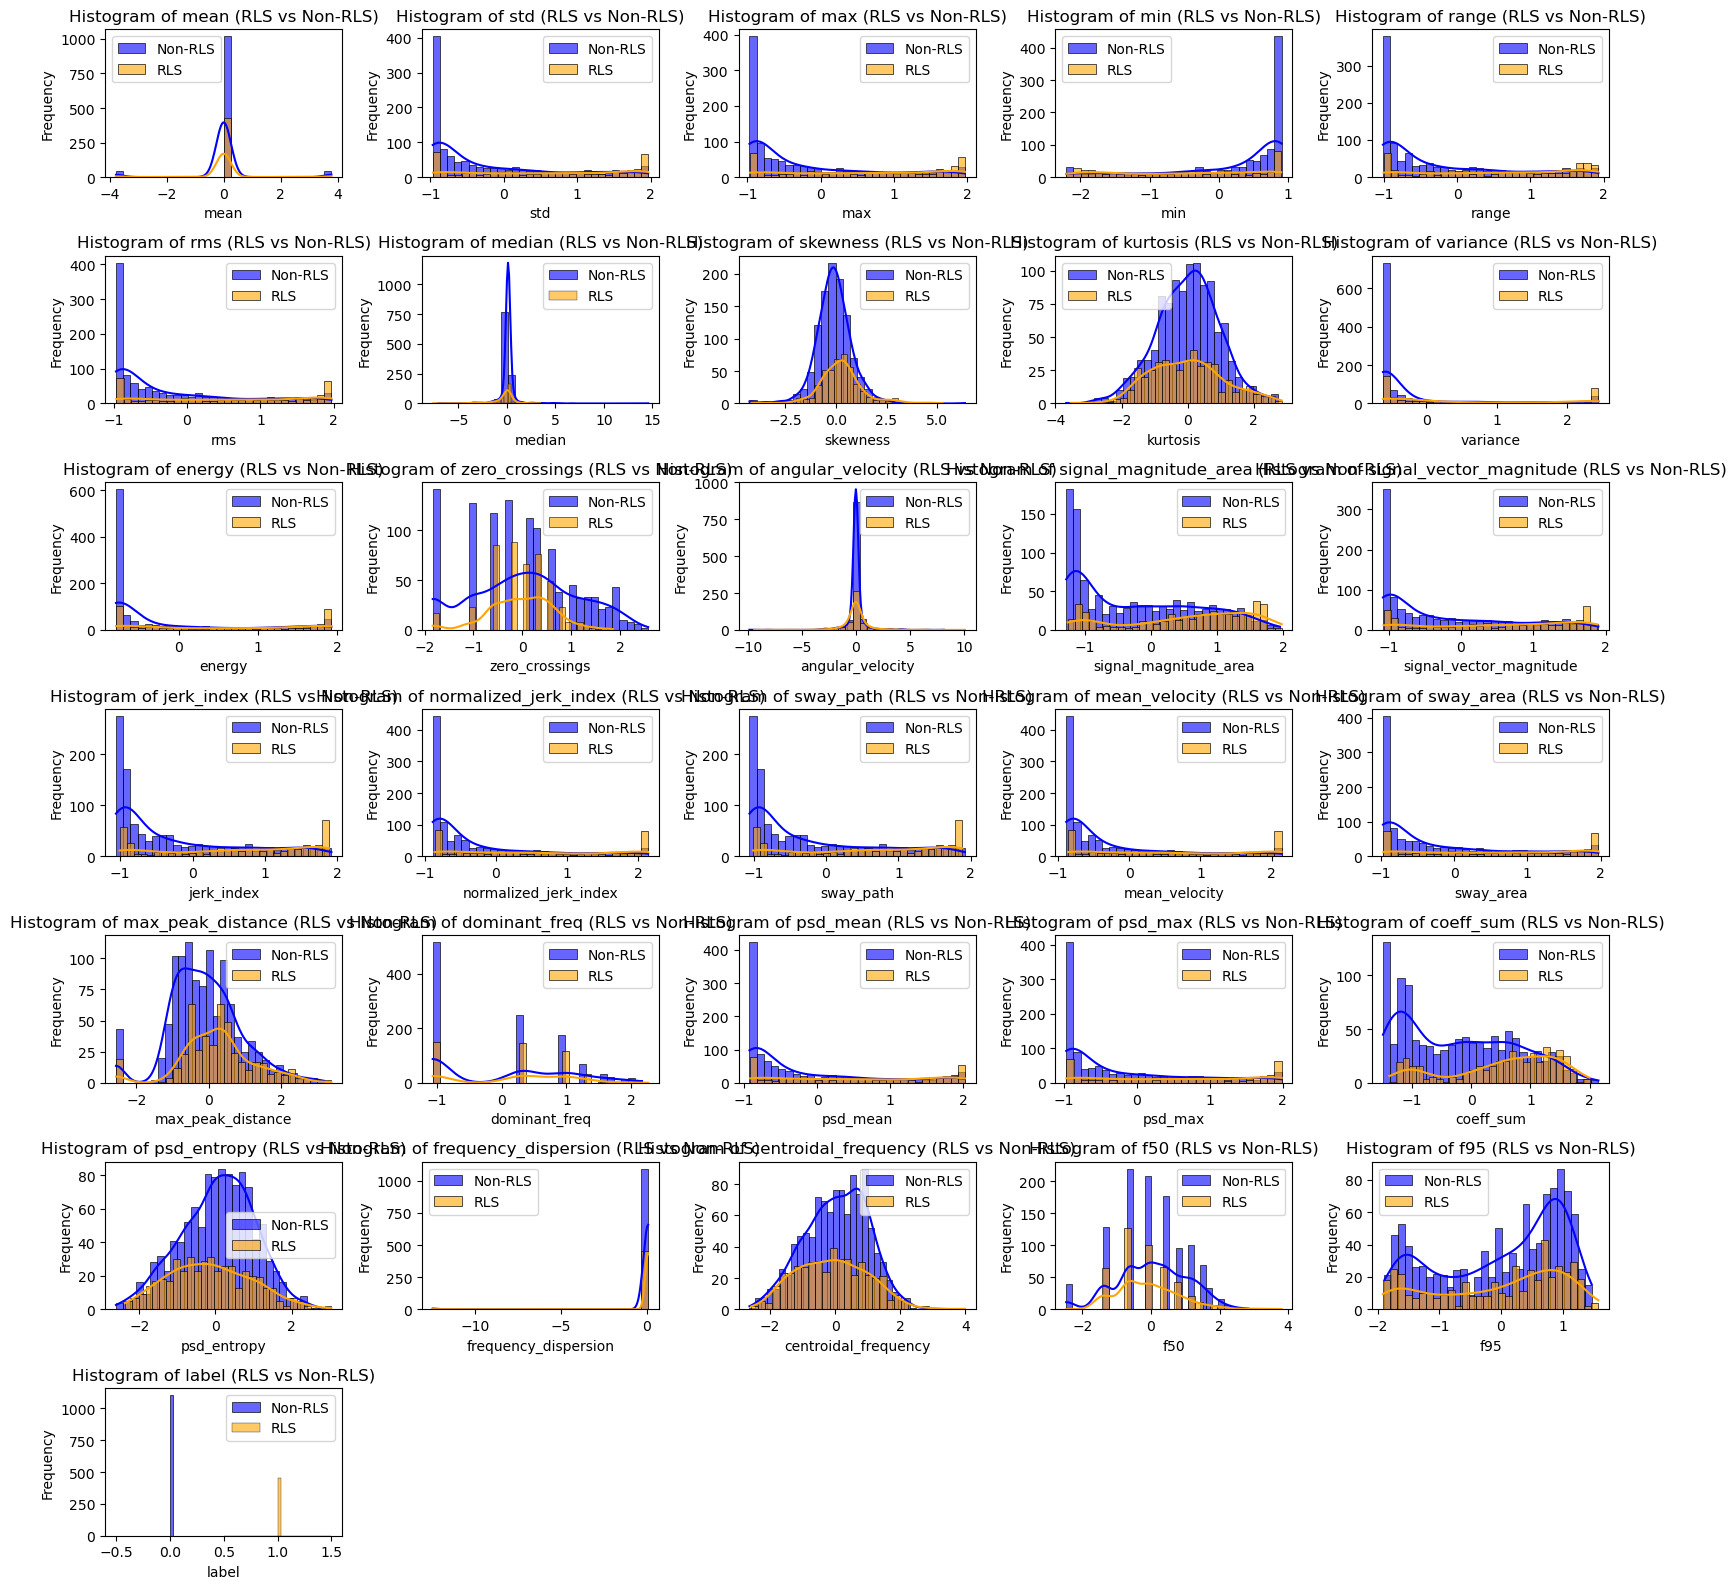

In [118]:
# Correlation matrix to explore feature relationships
plt.figure(figsize=(20, 20))
sns.heatmap(features_df_box_cox_zscore.corr(), annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Correlation Matrix of Extracted Features")
plt.show()

# Histogram to check skewness
plt.figure(figsize=(16, 16))
num_features = len(features_df_box_cox_zscore.columns) - 1  # Exclude the label column
rows = (num_features // 5) + 1
for i, feature in enumerate(features_df_box_cox_zscore[:-1], 1):  # Exclude the label column
    plt.subplot(rows, 5, i)

    sns.histplot(features_df_box_cox_zscore[features_df_box_cox_zscore['label'] == 0][feature], color='blue', label='Non-RLS', kde=True, bins=30, alpha=0.6)
    sns.histplot(features_df_box_cox_zscore[features_df_box_cox_zscore['label'] == 1][feature], color='orange', label='RLS', kde=True, bins=30, alpha=0.6)
    
    plt.title(f'Histogram of {feature} (RLS vs Non-RLS)')
    plt.xlabel(feature)
    plt.ylabel('Frequency')
    plt.legend()

plt.tight_layout()
plt.show()

# Target Labelling via K-means clustering

In [7]:
# Separate features and labels
X = features_df_box_cox_zscore[['max', 'normalized_jerk_index', 'sway_path', 'jerk_index', 'mean_velocity', 'zero_crossings','median', 'skewness','min','kurtosis']]
y = features_df_box_cox_zscore['label']

# Apply K-Means clustering
kmeans = KMeans(n_clusters=2, random_state=42)
features_df_box_cox_zscore['cluster'] = kmeans.fit_predict(features_df_box_cox_zscore.drop(columns=['label']))

C:\Users\khali\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\khali\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=7.
  warnings.warn(


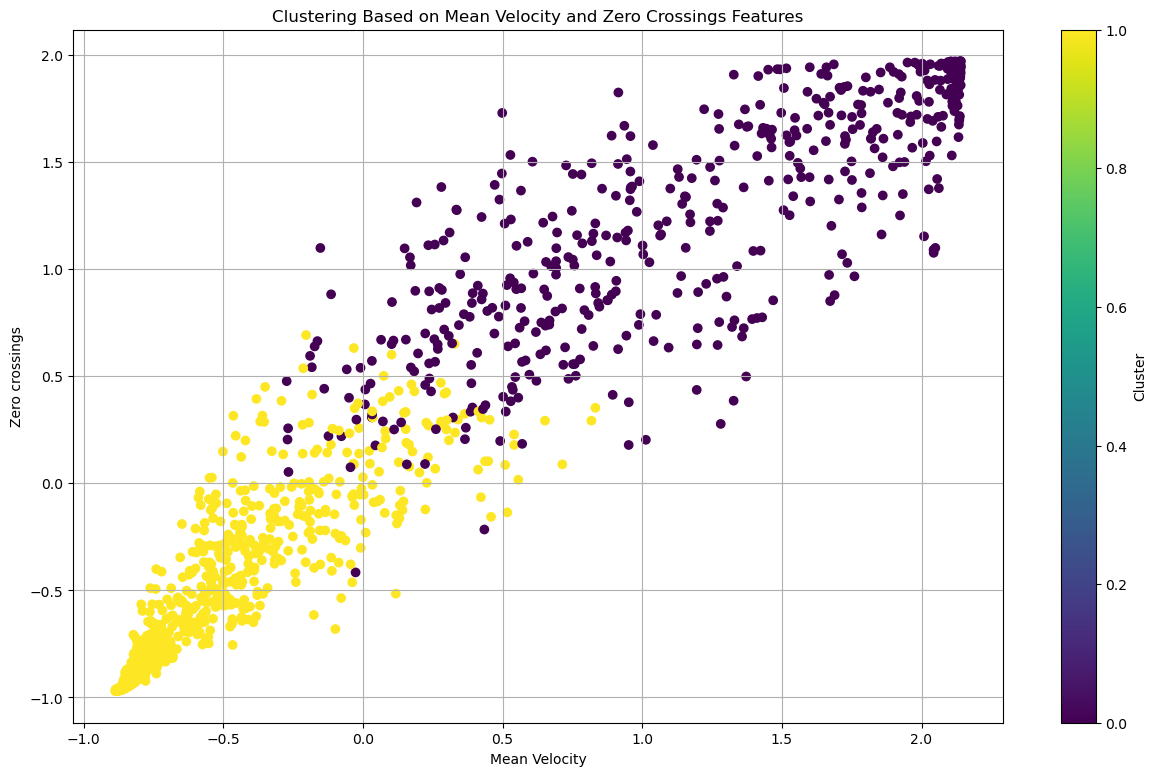

In [11]:
# Visualize clustering based on dominant frequency and number of peaks
plt.figure(figsize=(15, 9))
plt.scatter(features_df_box_cox_zscore['mean_velocity'], features_df_box_cox_zscore['max'], c=features_df_box_cox_zscore['cluster'], cmap='viridis')
plt.xlabel('Mean Velocity')
plt.ylabel('Zero crossings')
plt.title('Clustering Based on Mean Velocity and Zero Crossings Features')
plt.colorbar(label='Cluster')
plt.grid(True)
plt.show()

In [49]:
pd.crosstab(features_df_box_cox_zscore['label'], features_df_box_cox_zscore['cluster'], rownames=['Label'], colnames=['Cluster'])

Cluster    0    1
Label            
0        259  845
1        260  194

In [50]:
# Invert cluster labels (swap 0 with 1 and vice versa)
features_df_box_cox_zscore['cluster'] = features_df_box_cox_zscore['cluster'].apply(lambda x: 1 if x == 0 else 0)

# Verify the inversion
inverted_cluster_counts = pd.crosstab(features_df_box_cox_zscore['label'], features_df_box_cox_zscore['cluster'])
print(inverted_cluster_counts)

cluster    0    1
label            
0        845  259
1        194  260


# Silhoutte score

In [51]:
# Check cluster purity with a contingency table
contingency_table = pd.crosstab(features_df_box_cox_zscore['label'], features_df_box_cox_zscore['cluster'])
print("Cluster Purity:\n", contingency_table)

# Evaluate clustering performance with silhouette score
sil_score = silhouette_score(features_df_box_cox_zscore.drop(columns=['label', 'cluster']), features_df_box_cox_zscore['cluster'])
print(f"Silhouette Score: {sil_score:.3f}")


Cluster Purity:
 cluster    0    1
label            
0        845  259
1        194  260
Silhouette Score: 0.416


# Cluster distribution

In [52]:
# Check distribution of clusters
class_distribution = features_df_box_cox_zscore['cluster'].value_counts()
print("Class distribution of clusters (count):")
print(class_distribution)

# Calculate percentage distribution of clusters
class_distribution_percentage = features_df_box_cox_zscore['cluster'].value_counts(normalize=True) * 100
print("\nClass distribution of clusters (percentage):")
print(class_distribution_percentage)


Class distribution of clusters (count):
0    1039
1     519
Name: cluster, dtype: int64

Class distribution of clusters (percentage):
0    66.688062
1    33.311938
Name: cluster, dtype: float64


# Classification via Random Undersampling & Machine Learning 

In [53]:
from imblearn.under_sampling import RandomUnderSampler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

# Ensure X_subset has the selected features
X_subset = X  # Replace this with your selected feature DataFrame if needed

# Target variable
y = features_df_box_cox_zscore['cluster']

# Apply random undersampling to the entire dataset
undersampler = RandomUnderSampler(random_state=42)
X_resampled, y_resampled = undersampler.fit_resample(X_subset, y)

# Split the undersampled data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.3, random_state=42)

# Initialize the KNN classifier
knn = KNeighborsClassifier(n_neighbors=153)

# Train the KNN model on the training set
knn.fit(X_train, y_train)

# Predict on the training set for training metrics
y_train_pred = knn.predict(X_train)

# Predict on the test set
y_test_pred = knn.predict(X_test)

# Evaluate the model on the training set
train_accuracy = accuracy_score(y_train, y_train_pred)
train_precision = precision_score(y_train, y_train_pred, average='weighted')
train_recall = recall_score(y_train, y_train_pred, average='weighted')
train_f1 = f1_score(y_train, y_train_pred, average='weighted')

# Print training evaluation metrics
print("Training Set Evaluation:")
print(f"Accuracy: {train_accuracy}")
print(f"Precision: {train_precision}")
print(f"Recall: {train_recall}")
print(f"F1 Score: {train_f1}")

# Compute and display the confusion matrix for the training set
train_conf_matrix = confusion_matrix(y_train, y_train_pred)
print("Training Confusion Matrix:")
print(train_conf_matrix)

# Evaluate the model on the test set
test_accuracy = accuracy_score(y_test, y_test_pred)
test_precision = precision_score(y_test, y_test_pred, average='weighted')
test_recall = recall_score(y_test, y_test_pred, average='weighted')
test_f1 = f1_score(y_test, y_test_pred, average='weighted')

# Print test evaluation metrics
print("\nTest Set Evaluation:")
print(f"Accuracy: {test_accuracy}")
print(f"Precision: {test_precision}")
print(f"Recall: {test_recall}")
print(f"F1 Score: {test_f1}")

# Compute and display the confusion matrix for the test set
test_conf_matrix = confusion_matrix(y_test, y_test_pred)
print("Test Confusion Matrix:")
print(test_conf_matrix)

# Print classification report for both training and test sets
train_class_report = classification_report(y_train, y_train_pred)
test_class_report = classification_report(y_test, y_test_pred)

print("\nTraining Set Classification Report:")
print(train_class_report)
print("\nTest Set Classification Report:")
print(test_class_report)


Training Set Evaluation:
Accuracy: 0.9628099173553719
Precision: 0.9628893302249525
Recall: 0.9628099173553719
F1 Score: 0.9628039165295641
Training Confusion Matrix:
[[341  16]
 [ 11 358]]

Test Set Evaluation:
Accuracy: 0.9391025641025641
Precision: 0.9423536174781697
Recall: 0.9391025641025641
F1 Score: 0.9390944313486252
Test Confusion Matrix:
[[146  16]
 [  3 147]]

Training Set Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.96      0.96       357
           1       0.96      0.97      0.96       369

    accuracy                           0.96       726
   macro avg       0.96      0.96      0.96       726
weighted avg       0.96      0.96      0.96       726


Test Set Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.90      0.94       162
           1       0.90      0.98      0.94       150

    accuracy                           0.94       312
   macro avg

In [54]:
from imblearn.under_sampling import RandomUnderSampler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

# Ensure X_subset has the selected features
X_subset = X  # Replace this with your selected feature DataFrame if needed

# Target variable
y = features_df_box_cox_zscore['cluster']

# Apply random undersampling to the entire dataset
undersampler = RandomUnderSampler(random_state=42)
X_resampled, y_resampled = undersampler.fit_resample(X_subset, y)

# Split the undersampled data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.3, random_state=42)

# Initialize the SVM classifier
svm = SVC(kernel='rbf', C=1.0, gamma='scale', random_state=42)

# Train the SVM model on the training set
svm.fit(X_train, y_train)

# Predict on the training set for training metrics
y_train_pred = svm.predict(X_train)

# Predict on the test set
y_test_pred = svm.predict(X_test)

# Evaluate the model on the training set
train_accuracy = accuracy_score(y_train, y_train_pred)
train_precision = precision_score(y_train, y_train_pred, average='weighted')
train_recall = recall_score(y_train, y_train_pred, average='weighted')
train_f1 = f1_score(y_train, y_train_pred, average='weighted')

# Print training evaluation metrics
print("Training Set Evaluation:")
print(f"Accuracy: {train_accuracy}")
print(f"Precision: {train_precision}")
print(f"Recall: {train_recall}")
print(f"F1 Score: {train_f1}")

# Compute and display the confusion matrix for the training set
train_conf_matrix = confusion_matrix(y_train, y_train_pred)
print("Training Confusion Matrix:")
print(train_conf_matrix)

# Evaluate the model on the test set
test_accuracy = accuracy_score(y_test, y_test_pred)
test_precision = precision_score(y_test, y_test_pred, average='weighted')
test_recall = recall_score(y_test, y_test_pred, average='weighted')
test_f1 = f1_score(y_test, y_test_pred, average='weighted')

# Print test evaluation metrics
print("\nTest Set Evaluation:")
print(f"Accuracy: {test_accuracy}")
print(f"Precision: {test_precision}")
print(f"Recall: {test_recall}")
print(f"F1 Score: {test_f1}")

# Compute and display the confusion matrix for the test set
test_conf_matrix = confusion_matrix(y_test, y_test_pred)
print("Test Confusion Matrix:")
print(test_conf_matrix)

# Print classification report for both training and test sets
train_class_report = classification_report(y_train, y_train_pred)
test_class_report = classification_report(y_test, y_test_pred)

print("\nTraining Set Classification Report:")
print(train_class_report)
print("\nTest Set Classification Report:")
print(test_class_report)


Training Set Evaluation:
Accuracy: 0.9889807162534435
Precision: 0.9890381270992017
Recall: 0.9889807162534435
F1 Score: 0.9889793775909785
Training Confusion Matrix:
[[351   6]
 [  2 367]]

Test Set Evaluation:
Accuracy: 0.9711538461538461
Precision: 0.9716734364874902
Recall: 0.9711538461538461
F1 Score: 0.9711642230014191
Test Confusion Matrix:
[[155   7]
 [  2 148]]

Training Set Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.98      0.99       357
           1       0.98      0.99      0.99       369

    accuracy                           0.99       726
   macro avg       0.99      0.99      0.99       726
weighted avg       0.99      0.99      0.99       726


Test Set Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.96      0.97       162
           1       0.95      0.99      0.97       150

    accuracy                           0.97       312
   macro avg

In [55]:
from imblearn.under_sampling import RandomUnderSampler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

# Ensure X_subset has the selected features
X_subset = X  # Replace this with your selected feature DataFrame if needed

# Target variable
y = features_df_box_cox_zscore['cluster']

# Apply random undersampling to the entire dataset
undersampler = RandomUnderSampler(random_state=42)
X_resampled, y_resampled = undersampler.fit_resample(X_subset, y)

# Split the undersampled data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.3, random_state=42)

# Initialize the MLP classifier
mlp = MLPClassifier(hidden_layer_sizes=(100,), max_iter=300, random_state=42)

# Train the MLP model on the training set
mlp.fit(X_train, y_train)

# Predict on the training set for training metrics
y_train_pred = mlp.predict(X_train)

# Predict on the test set
y_test_pred = mlp.predict(X_test)

# Evaluate the model on the training set
train_accuracy = accuracy_score(y_train, y_train_pred)
train_precision = precision_score(y_train, y_train_pred, average='weighted')
train_recall = recall_score(y_train, y_train_pred, average='weighted')
train_f1 = f1_score(y_train, y_train_pred, average='weighted')

# Print training evaluation metrics
print("Training Set Evaluation:")
print(f"Accuracy: {train_accuracy}")
print(f"Precision: {train_precision}")
print(f"Recall: {train_recall}")
print(f"F1 Score: {train_f1}")

# Compute and display the confusion matrix for the training set
train_conf_matrix = confusion_matrix(y_train, y_train_pred)
print("Training Confusion Matrix:")
print(train_conf_matrix)

# Evaluate the model on the test set
test_accuracy = accuracy_score(y_test, y_test_pred)
test_precision = precision_score(y_test, y_test_pred, average='weighted')
test_recall = recall_score(y_test, y_test_pred, average='weighted')
test_f1 = f1_score(y_test, y_test_pred, average='weighted')

# Print test evaluation metrics
print("\nTest Set Evaluation:")
print(f"Accuracy: {test_accuracy}")
print(f"Precision: {test_precision}")
print(f"Recall: {test_recall}")
print(f"F1 Score: {test_f1}")

# Compute and display the confusion matrix for the test set
test_conf_matrix = confusion_matrix(y_test, y_test_pred)
print("Test Confusion Matrix:")
print(test_conf_matrix)

# Print classification report for both training and test sets
train_class_report = classification_report(y_train, y_train_pred)
test_class_report = classification_report(y_test, y_test_pred)

print("\nTraining Set Classification Report:")
print(train_class_report)
print("\nTest Set Classification Report:")
print(test_class_report)


Training Set Evaluation:
Accuracy: 0.9944903581267218
Precision: 0.994504874247826
Recall: 0.9944903581267218
F1 Score: 0.9944900653276546
Training Confusion Matrix:
[[354   3]
 [  1 368]]

Test Set Evaluation:
Accuracy: 0.9775641025641025
Precision: 0.9777573825853515
Recall: 0.9775641025641025
F1 Score: 0.9775703307210665
Test Confusion Matrix:
[[157   5]
 [  2 148]]

Training Set Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.99      0.99       357
           1       0.99      1.00      0.99       369

    accuracy                           0.99       726
   macro avg       0.99      0.99      0.99       726
weighted avg       0.99      0.99      0.99       726


Test Set Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.97      0.98       162
           1       0.97      0.99      0.98       150

    accuracy                           0.98       312
   macro avg 

In [57]:
from imblearn.under_sampling import RandomUnderSampler
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

# Ensure X_subset has the selected features
X_subset = X  # Replace this with your selected feature DataFrame if needed

# Target variable
y = features_df_box_cox_zscore['cluster']

# Apply random undersampling to the entire dataset
undersampler = RandomUnderSampler(random_state=42)
X_resampled, y_resampled = undersampler.fit_resample(X_subset, y)

# Split the undersampled data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.3, random_state=42)

# Initialize the Naive Bayes model
nb_model = GaussianNB()

# Train the Naive Bayes model on the training set
nb_model.fit(X_train, y_train)

# Predict on the training set for training metrics
y_train_pred = nb_model.predict(X_train)

# Predict on the test set
y_test_pred = nb_model.predict(X_test)

# Evaluate the model on the training set
train_accuracy = accuracy_score(y_train, y_train_pred)
train_precision = precision_score(y_train, y_train_pred, average='weighted')
train_recall = recall_score(y_train, y_train_pred, average='weighted')
train_f1 = f1_score(y_train, y_train_pred, average='weighted')

# Print training evaluation metrics
print("Training Set Evaluation:")
print(f"Accuracy: {train_accuracy}")
print(f"Precision: {train_precision}")
print(f"Recall: {train_recall}")
print(f"F1 Score: {train_f1}")

# Compute and display the confusion matrix for the training set
train_conf_matrix = confusion_matrix(y_train, y_train_pred)
print("Training Confusion Matrix:")
print(train_conf_matrix)

# Evaluate the model on the test set
test_accuracy = accuracy_score(y_test, y_test_pred)
test_precision = precision_score(y_test, y_test_pred, average='weighted')
test_recall = recall_score(y_test, y_test_pred, average='weighted')
test_f1 = f1_score(y_test, y_test_pred, average='weighted')

# Print test evaluation metrics
print("\nTest Set Evaluation:")
print(f"Accuracy: {test_accuracy}")
print(f"Precision: {test_precision}")
print(f"Recall: {test_recall}")
print(f"F1 Score: {test_f1}")

# Compute and display the confusion matrix for the test set
test_conf_matrix = confusion_matrix(y_test, y_test_pred)
print("Test Confusion Matrix:")
print(test_conf_matrix)

# Print classification report for both training and test sets
train_class_report = classification_report(y_train, y_train_pred)
test_class_report = classification_report(y_test, y_test_pred)

print("\nTraining Set Classification Report:")
print(train_class_report)
print("\nTest Set Classification Report:")
print(test_class_report)


Training Set Evaluation:
Accuracy: 0.9696969696969697
Precision: 0.9701949311672009
Recall: 0.9696969696969697
F1 Score: 0.9696803936803936
Training Confusion Matrix:
[[340  17]
 [  5 364]]

Test Set Evaluation:
Accuracy: 0.9487179487179487
Precision: 0.9536607970342911
Recall: 0.9487179487179487
F1 Score: 0.9486842271652398
Test Confusion Matrix:
[[146  16]
 [  0 150]]

Training Set Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.95      0.97       357
           1       0.96      0.99      0.97       369

    accuracy                           0.97       726
   macro avg       0.97      0.97      0.97       726
weighted avg       0.97      0.97      0.97       726


Test Set Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.90      0.95       162
           1       0.90      1.00      0.95       150

    accuracy                           0.95       312
   macro avg

# Evaluation Metrics Plot

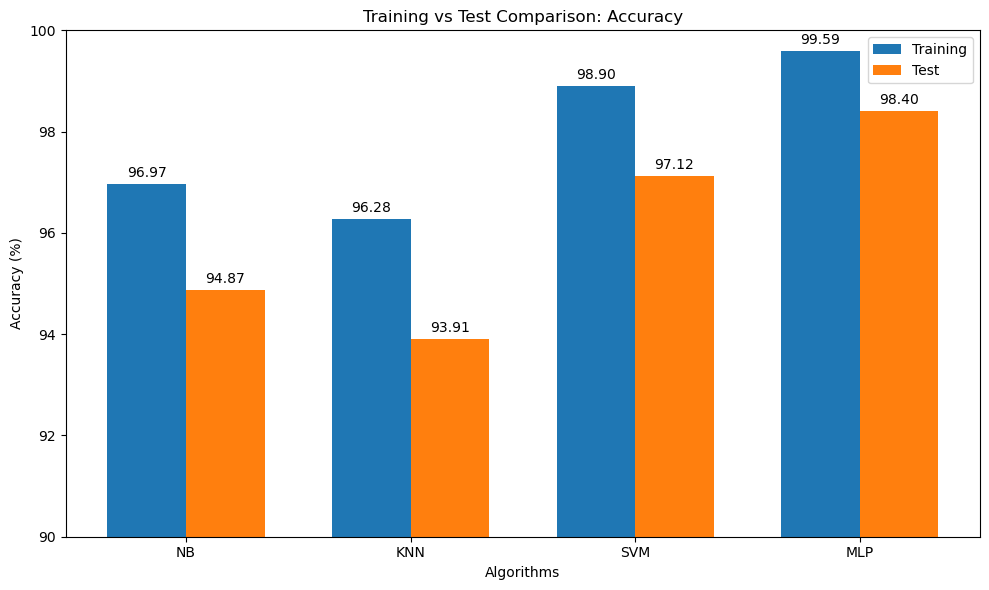

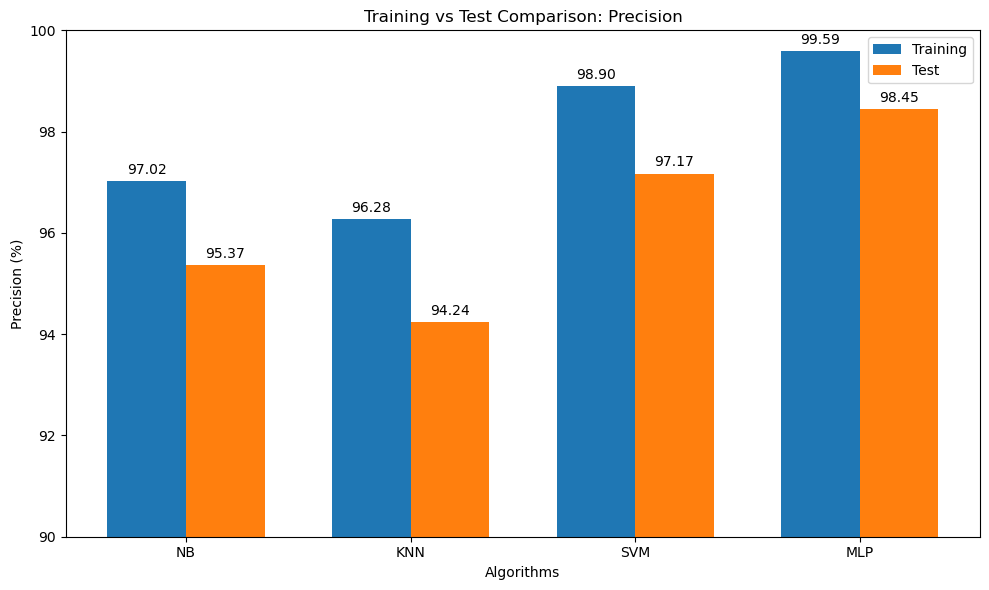

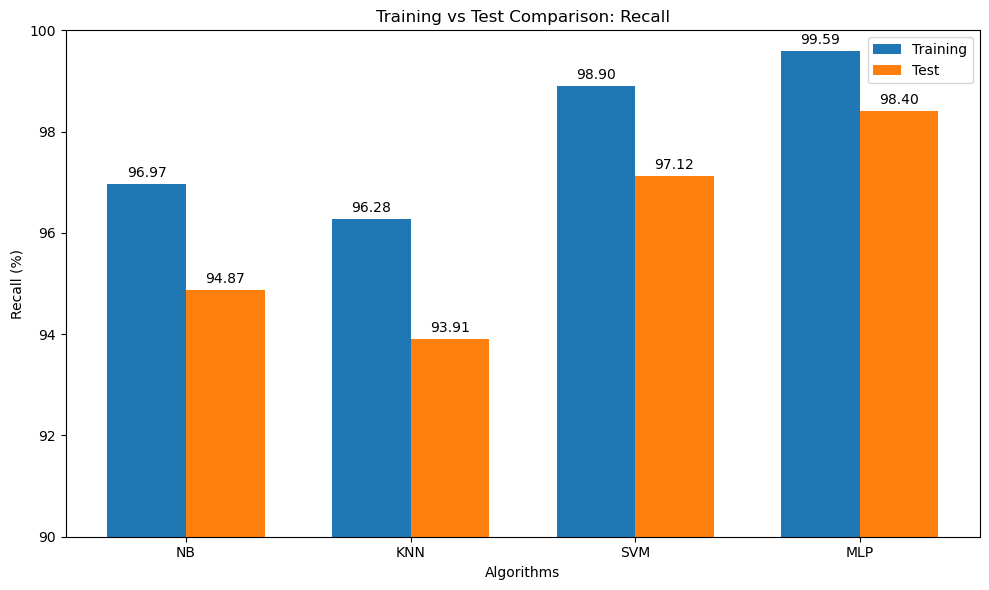

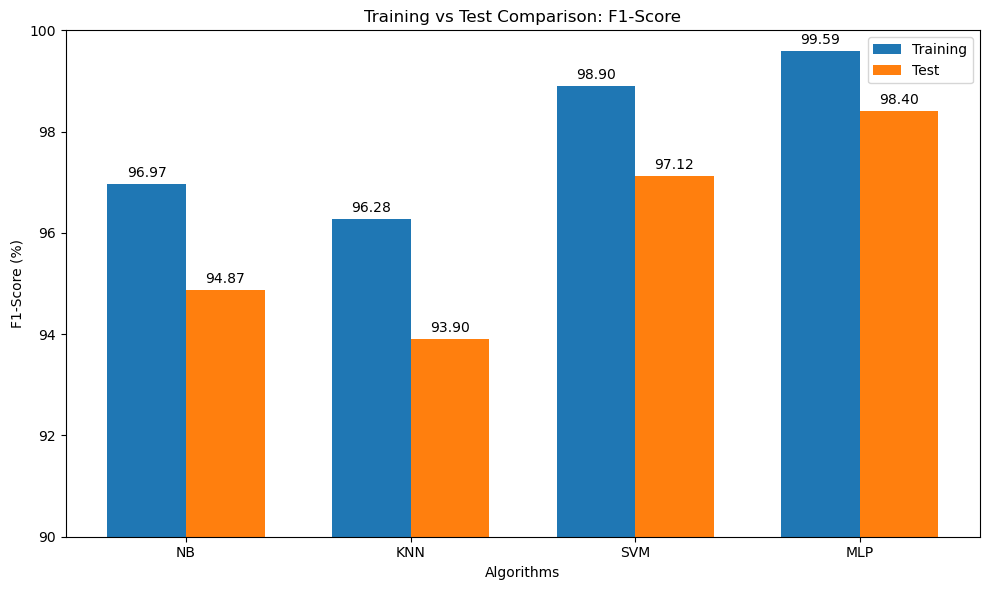

In [1]:
# Define data
algorithms = ['NB', 'KNN', 'SVM', 'MLP']
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']

training_scores = {
    'Accuracy': [96.97, 96.28, 98.90, 99.59],
    'Precision': [97.02, 96.28, 98.90, 99.59],
    'Recall': [96.97, 96.28, 98.90, 99.59],
    'F1-Score': [96.97, 96.28, 98.90, 99.59]
}

test_scores = {
    'Accuracy': [94.87, 93.91, 97.12, 98.40],
    'Precision': [95.37, 94.24, 97.17, 98.45],
    'Recall': [94.87, 93.91, 97.12, 98.40],
    'F1-Score': [94.87, 93.90, 97.12, 98.40]
}

# Plot bar chart comparison for training vs test for each metric
def plot_training_vs_test(training_scores, test_scores, algorithms, metrics):
    x = np.arange(len(algorithms))  # the label locations
    width = 0.35  # the width of the bars

    for metric in metrics:
        fig, ax = plt.subplots(figsize=(10, 6))

        bars1 = ax.bar(x - width/2, training_scores[metric], width, label='Training')
        bars2 = ax.bar(x + width/2, test_scores[metric], width, label='Test')

        # Add some text for labels, title and custom x-axis tick labels, etc.
        ax.set_xlabel('Algorithms')
        ax.set_ylabel(f'{metric} (%)')
        ax.set_title(f'Training vs Test Comparison: {metric}')
        ax.set_xticks(x)
        ax.set_xticklabels(algorithms)
        ax.legend()

        # Add value annotations
        for bars in [bars1, bars2]:
            for bar in bars:
                height = bar.get_height()
                ax.annotate(f'{height:.2f}',
                            xy=(bar.get_x() + bar.get_width() / 2, height),
                            xytext=(0, 3),  # 3 points vertical offset
                            textcoords="offset points",
                            ha='center', va='bottom')

        plt.ylim(90, 100)  # Set y-axis limit
        plt.tight_layout()
        plt.show()

# Call the function to plot
plot_training_vs_test(training_scores, test_scores, algorithms, metrics)


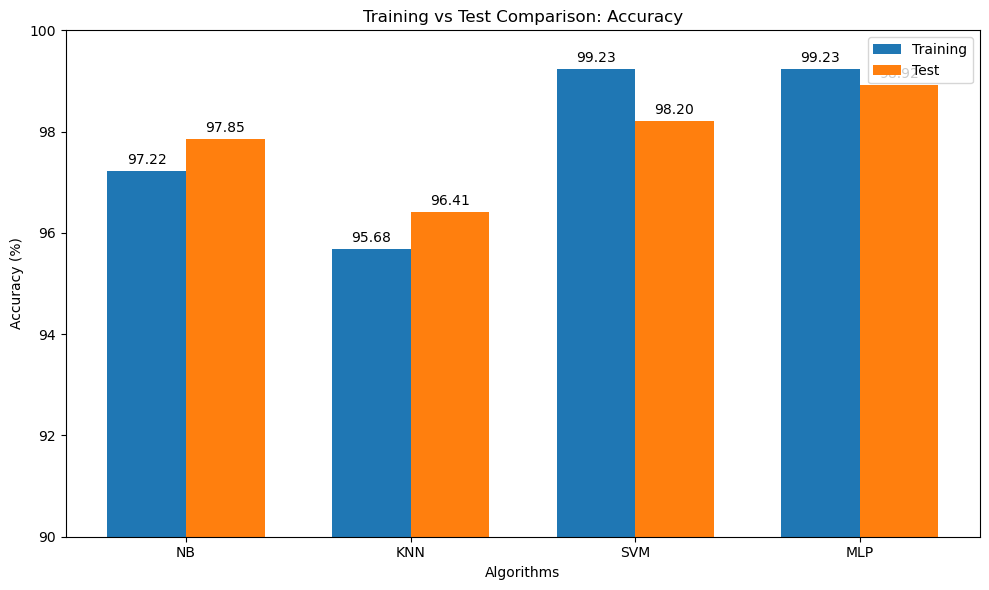

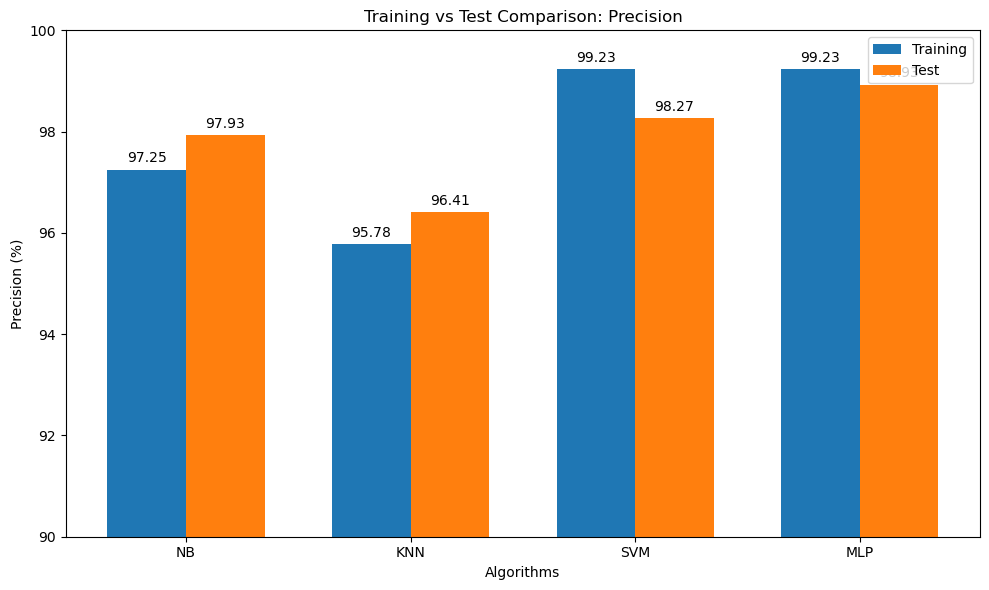

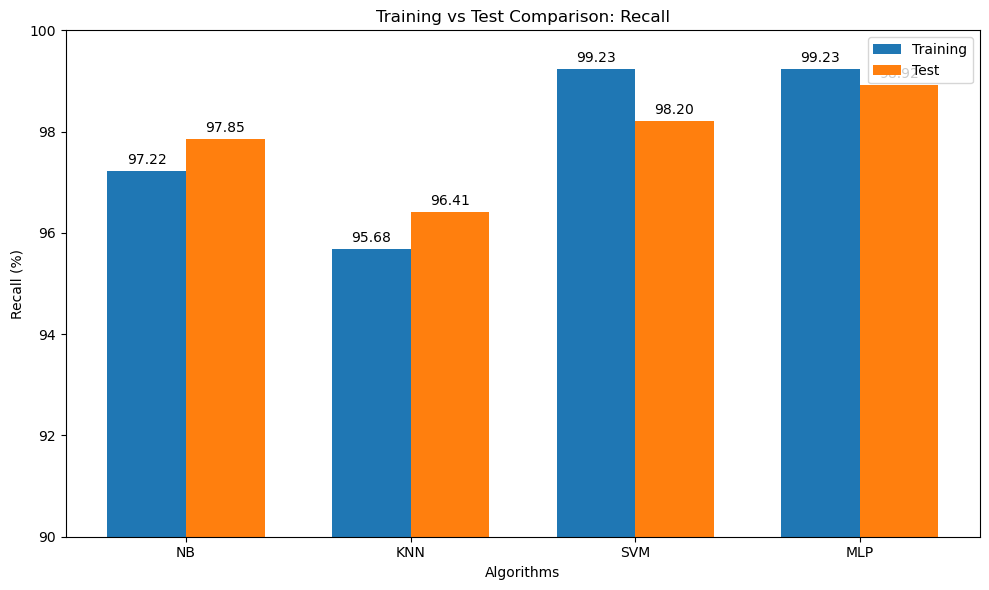

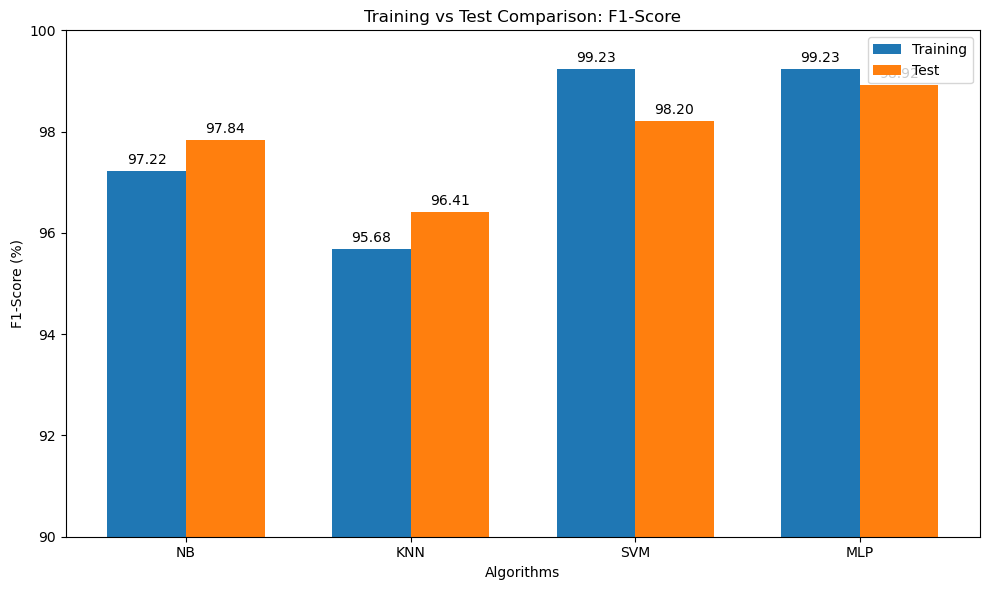

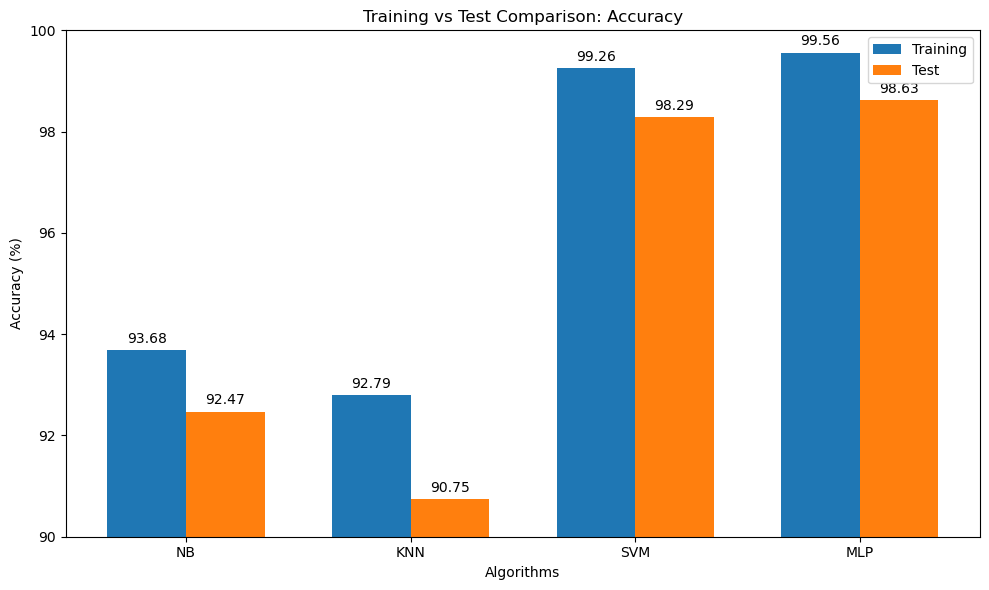

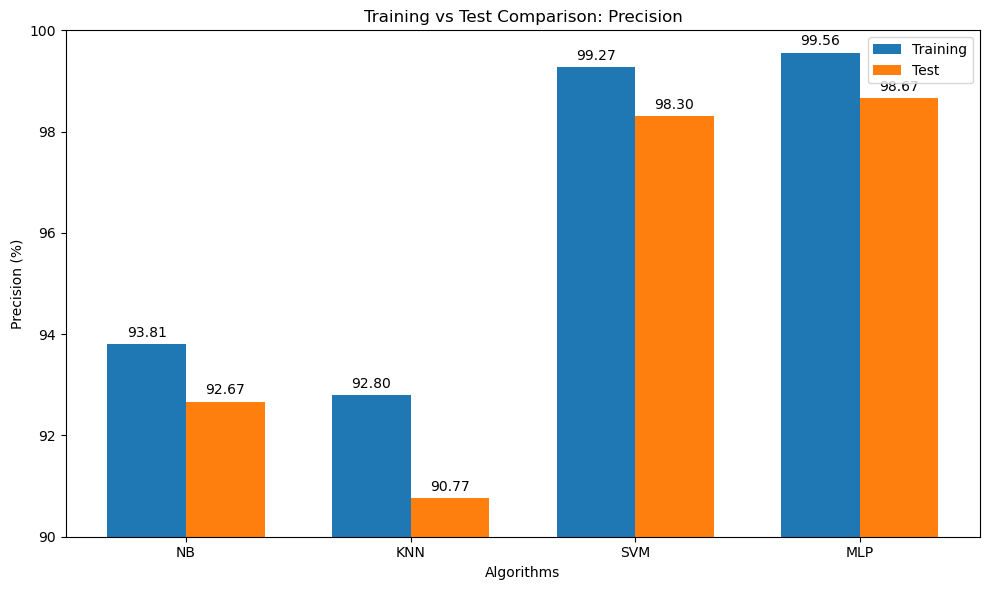

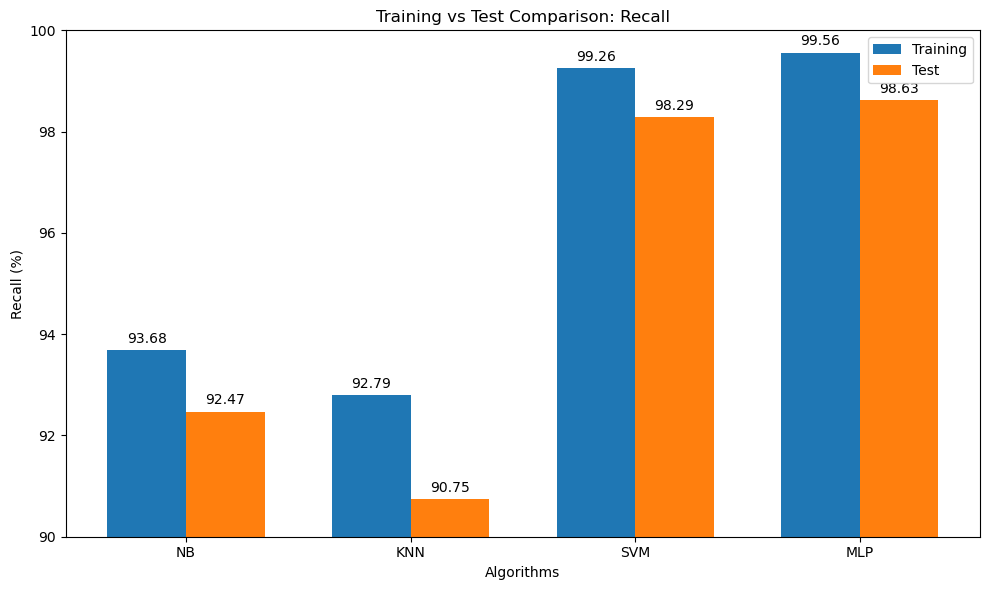

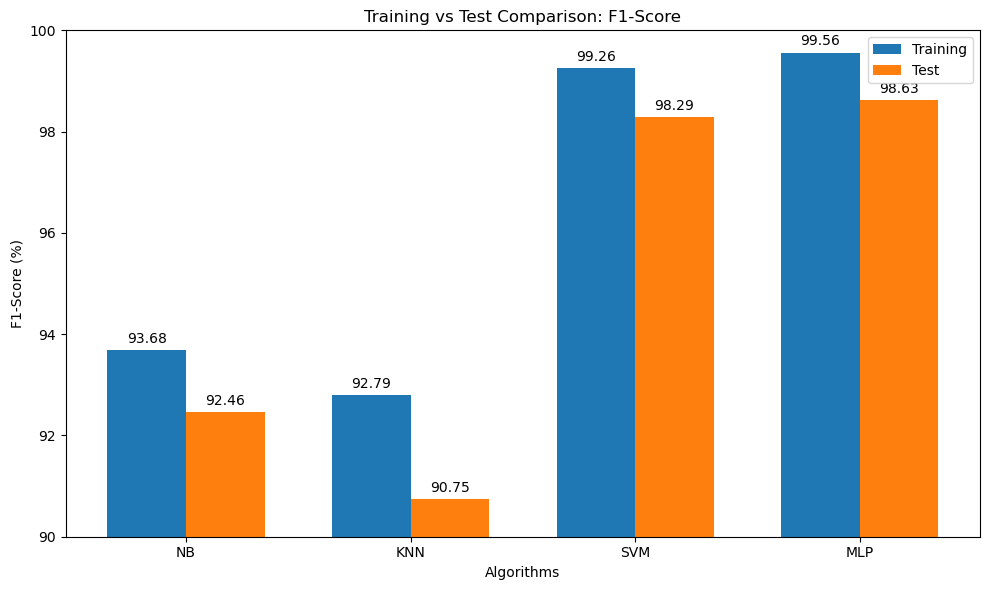